In [1]:
import os
import yaml
import urllib
from PIL import Image
from enum import Enum
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import xml.etree.cElementTree as ET
import glob
import argparse
import numpy as np
import json
import numpy
import cv2
from collections import OrderedDict
import scipy.misc
from skimage import measure   
import random
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import shutil
import pickle
import pandas as pd

WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet/darknet_evaluate'
COCO_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'data', 'coco')
BDD10K_COCO_ANNOTATIONS_FILE = os.path.join(COCO_DIRECTORY,'annotations' , 'bdd10k_instances_val2014.json')
IMAGES_DIRECTORY = os.path.join(COCO_DIRECTORY, 'images','train2014')
WEIGHTS_DIRECTORY = os.path.join(WORKING_DIRECTORY,'trained_weights')
LABELS_DIRECTORY = os.path.join(COCO_DIRECTORY, 'labels','train2014')
CATEGORY_NAMES = os.path.join(WORKING_DIRECTORY, 'data', 'coco.bdd100k.names')

In [2]:
bdd10k_coco = COCO(BDD10K_COCO_ANNOTATIONS_FILE)
ann_ids = bdd10k_coco.getAnnIds()
print(len(ann_ids))

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
185526


In [3]:
# For Run in Training Runs    
training_runs = os.listdir(os.path.join(WEIGHTS_DIRECTORY,'training_runs'))
all_runs = []
#for run in [training_runs[1]]:
for run in training_runs:
    print('Evaluating mAP on Training Run:', os.path.join(WEIGHTS_DIRECTORY,'training_runs',run))
    # Grab iterations and sort checkpoints
    d = {}
    weights_files = glob.glob(os.path.join(WEIGHTS_DIRECTORY,'training_runs',run, '*.weights'))
    
    for fpath in weights_files:
        fname = os.path.split(fpath)[-1]
        iterations = fname[15:].split('.weights')[0]
        if iterations != 'final':
            d[fname] = int(iterations)
        else:
            d[fname] = 100000
    sorted_weights = OrderedDict(sorted(d.items(), key=lambda kv: kv[1]))
    bdd_weights = OrderedDict()

    for weights_file in sorted_weights.keys():
        d = {}
        d['iterations'] = sorted_weights[weights_file]
        d['map_results_file'] = os.path.join(WEIGHTS_DIRECTORY, 'training_runs',run, weights_file+'.txt')
        map_results_file = d['map_results_file']
        d['map_results_file'] = d['map_results_file'] +'.backup'

        if not os.path.exists(d['map_results_file']):
            # Create annotations if labels directory not found
            if not os.path.exists(os.path.join(COCO_DIRECTORY,'labels/train2014/manifast.txt')):
                #!java -jar $WORKING_DIRECTORY/data/cocotoyolo.jar "{BDD10K_COCO_ANNOTATIONS_FILE}" "{IMAGES_DIRECTORY}/" "all" "{COCO_DIRECTORY}/labels/train2014"
                yolo_convert_output = os.path.join(COCO_DIRECTORY, 'labels','convert2yolo_results.txt')
                !python3 $WORKING_DIRECTORY/convert2Yolo/example.py --datasets COCO --img_path "{IMAGES_DIRECTORY}" --label "{BDD10K_COCO_ANNOTATIONS_FILE}" --convert_output_path "{LABELS_DIRECTORY}" --img_type ".jpg" --manipast_path $LABELS_DIRECTORY --cls_list_file $CATEGORY_NAMES | tee -a $yolo_convert_output
                
            CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs',run, weights_file)
            outfile = !cd $WORKING_DIRECTORY && ./darknet detector map cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT | tee -a $map_results_file
            with open(d['map_results_file'],"w+") as f:
                outfile = '\n'.join(outfile)
                f.write(outfile)

        #Get mAP results from file
        class_stats = []
        map_stats = {}
        with open(d['map_results_file']) as openfile:
            for line in openfile:
                for part in line.split():
                    if 'class_id' in part:
                        class_map = {}
                        if 'class_id =' in line:
                            id_tokens = line.split('class_id =')[1].split(',')
                            if id_tokens[0] in [str(i) for i in range(10)]: 
                                class_map['class_id'] = int(id_tokens[0].strip())
                        
                        if 'name =' in line:
                            name_tokens = line.split('name =')[1].split(',')
                            class_map['class_name'] = name_tokens[0].strip()

                        if 'ap =' in line:
                            ap_tokens = line.split('ap =')[1].split(',')
                            class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                        class_stats.append(class_map)
                    elif '(mAP)' in part:
                        tokens = line.split('(mAP) =')[1]
                        map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
                    elif 'Detection' in part:
                        tokens = line.split(':')[1]
                        total_detection_time = str(''.join(tokens)).strip()
                        map_stats['total_detection_time'] = total_detection_time
                    elif 'average IoU' and  'average IoU =' in line:
                        tokens = line.split('average IoU =')[1].split(',')
                        map_stats['avg_IoU'] = tokens[0].split('%')[0].strip()
                
        map_stats['weights'] = d
        map_stats['class_stats'] = class_stats
        print(map_stats,'\n\n') 
        bdd_weights[weights_file] = map_stats

    # Make sure Dictionary is made properly
    all_runs.append((run, bdd_weights))

# Cache Data    
pickle_file = os.path.join(COCO_DIRECTORY, 'mAP_all_runs.pickle')
pickle_dict = {'all_runs': all_runs}
with open(pickle_file,"wb") as pickle_out:
    pickle.dump(pickle_dict, pickle_out)   

Evaluating mAP on Training Run: /media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run5_multi_gpu_lr0005_128bacth
{'total_detection_time': '299.000000 Seconds', 'avg_IoU': '34.65', 'mean_avg_precision': '26.72', 'weights': {'iterations': 2188, 'map_results_file': '/media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run5_multi_gpu_lr0005_128bacth/yolov3-bdd100k_2188.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '28.94'}, {'class_name': 'rider', 'class_ap': '18.43'}, {'class_name': 'car', 'class_ap': '55.81'}, {'class_name': 'truck', 'class_ap': '39.65'}, {'class_name': 'bus', 'class_ap': '33.61'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '13.79'}, {'class_name': 'bike', 'class_ap': '16.89'}, {'class_name': 'traffic sign', 'class_ap': '34.29'}, {'class_name': 'traffic light', 'class_ap': '25.78'}]} 


{'total_detection_time': '303.000000 Seconds', 'a

{'total_detection_time': '265.000000 Seconds', 'avg_IoU': '46.13', 'mean_avg_precision': '43.36', 'weights': {'iterations': 37196, 'map_results_file': '/media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run5_multi_gpu_lr0005_128bacth/yolov3-bdd100k_37196.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '42.74'}, {'class_name': 'rider', 'class_ap': '37.74'}, {'class_name': 'car', 'class_ap': '64.78'}, {'class_name': 'truck', 'class_ap': '57.22'}, {'class_name': 'bus', 'class_ap': '57.55'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '36.23'}, {'class_name': 'bike', 'class_ap': '39.59'}, {'class_name': 'traffic sign', 'class_ap': '56.67'}, {'class_name': 'traffic light', 'class_ap': '41.05'}]} 


{'total_detection_time': '281.000000 Seconds', 'avg_IoU': '50.17', 'mean_avg_precision': '43.53', 'weights': {'iterations': 40478, 'map_results_file': '/media/dean/datastore1/datasets/darknet/darkn

{'total_detection_time': '286.000000 Seconds', 'avg_IoU': '49.17', 'mean_avg_precision': '43.83', 'weights': {'iterations': 70000, 'map_results_file': '/media/dean/datastore1/datasets/darknet/darknet_evaluate/trained_weights/training_runs/run5_multi_gpu_lr0005_128bacth/yolov3-bdd100k_70000.weights.txt.backup'}, 'class_stats': [{'class_name': 'person', 'class_ap': '43.70'}, {'class_name': 'rider', 'class_ap': '38.37'}, {'class_name': 'car', 'class_ap': '65.89'}, {'class_name': 'truck', 'class_ap': '56.55'}, {'class_name': 'bus', 'class_ap': '57.44'}, {'class_name': 'train', 'class_ap': '0.00'}, {'class_name': 'motor', 'class_ap': '34.94'}, {'class_name': 'bike', 'class_ap': '37.80'}, {'class_name': 'traffic sign', 'class_ap': '59.02'}, {'class_name': 'traffic light', 'class_ap': '44.56'}]} 




In [4]:
print(len(bdd_weights))

27


## Plot Metrics


In [5]:
bdd_data = []
for run, bdd_weights in all_runs:
    for weights, map_stats in bdd_weights.items():
        d = {}
        d['training_run'] = run
        d['map_results_file'] = map_stats['weights']['map_results_file']
        d['iterations'] = map_stats['weights']['iterations']
        d['mean_avg_precision'] = map_stats['mean_avg_precision']
        d['person_ap'], d['rider_ap'], d['car_ap'], d['truck_ap'], d['bus_ap'], d['train_ap'], d['motor_ap'], d['bike_ap'], d['traffic_sign_ap'], d['traffic_light_ap'] = [0.0]*10
        
                    
        for cls in map_stats['class_stats']:
            cls_name = cls.get('class_name', '').strip()
            if cls_name == 'person':
                d['person_ap'] = cls['class_ap']
            elif cls_name == 'rider':
                d['rider_ap'] = cls['class_ap']
            elif cls_name == 'car':
                d['car_ap'] = cls['class_ap']
            elif cls_name == 'truck':
                d['truck_ap'] = cls['class_ap']
            elif cls_name == 'bus':
                d['bus_ap'] = cls['class_ap']
            elif cls_name == 'train':
                d['train_ap'] = cls['class_ap']
            elif cls_name == 'motor':
                d['motor_ap'] = cls['class_ap']
            elif cls_name == 'bike':
                d['bike_ap'] = cls['class_ap']
            elif cls_name == 'traffic sign':
                d['traffic_sign_ap'] = cls['class_ap']
            elif cls_name == 'traffic light':
                d['traffic_light_ap'] = cls['class_ap']
        d['total_detection_time'] = map_stats['total_detection_time']
        d['avg_IoU'] = map_stats.get('avg_IoU','')
        bdd_data.append(d)
data = pd.DataFrame(bdd_data)
data = data.apply(pd.to_numeric, errors='ignore')
data.head(100)

,avg_IoU,bike_ap,bus_ap,car_ap,iterations,map_results_file,mean_avg_precision,motor_ap,person_ap,rider_ap,total_detection_time,traffic_light_ap,traffic_sign_ap,train_ap,training_run,truck_ap
0,34.65,16.89,33.61,55.81,2188,/media/dean/datastore1/datasets/darknet/darkne...,26.72,13.79,28.94,18.43,299.000000 Seconds,25.78,34.29,0.00,run5_multi_gpu_lr0005_128bacth,39.65
1,40.95,24.58,43.30,61.23,5470,/media/dean/datastore1/datasets/darknet/darkne...,33.68,20.36,34.01,27.16,303.000000 Seconds,28.32,49.29,0.00,run5_multi_gpu_lr0005_128bacth,48.58
2,46.81,30.20,49.09,62.99,9846,/media/dean/datastore1/datasets/darknet/darkne...,38.16,23.11,38.32,29.61,293.000000 Seconds,42.45,54.95,0.00,run5_multi_gpu_lr0005_128bacth,50.89
3,45.89,30.40,48.42,62.96,10940,/media/dean/datastore1/datasets/darknet/darkne...,38.68,26.44,39.18,32.99,291.000000 Seconds,39.56,54.89,0.00,run5_multi_gpu_lr0005_128bacth,51.97
4,49.55,34.18,53.23,64.86,19692,/media/dean/datastore1/datasets/darknet/darkne...,41.34,29.37,43.06,34.38,287.000000 Seconds,41.46,57.05,0.00,run5_multi_gpu_lr0005_128bacth,55.81
5,45.96,34.38,55.01,64.55,22974,/media/dean/datastore1/datasets/darknet/darkne...,40.94,29.45,42.84,33.99,284.000000 Seconds,41.02,54.45,0.00,run5_multi_gpu_lr0005_128bacth,53.75
6,49.90,37.40,55.70,65.69,27350,/media/dean/datastore1/datasets/darknet/darkne...,43.43,34.95,43.68,36.38,276.000000 Seconds,45.31,58.42,0.00,run5_multi_gpu_lr0005_128bacth,56.78
7,49.86,36.68,54.24,65.34,28444,/media/dean/datastore1/datasets/darknet/darkne...,42.57,33.52,42.89,37.66,270.000000 Seconds,43.07,56.86,0.00,run5_multi_gpu_lr0005_128bacth,55.45
8,49.36,36.41,56.28,65.23,31726,/media/dean/datastore1/datasets/darknet/darkne...,43.75,36.26,44.31,38.10,435.000000 Seconds,44.77,58.65,0.00,run5_multi_gpu_lr0005_128bacth,57.46
9,47.51,35.49,56.11,64.84,32820,/media/dean/datastore1/datasets/darknet/darkne...,42.48,31.71,42.45,37.66,243.000000 Seconds,42.67,57.66,0.00,run5_multi_gpu_lr0005_128bacth,56.15


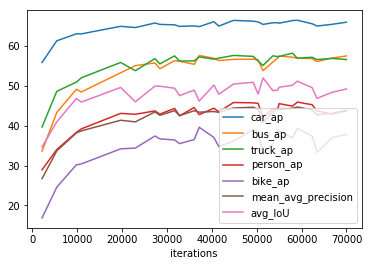

In [6]:
%matplotlib inline 
data.plot(x='iterations',y=['car_ap', 'bus_ap', 'truck_ap', 'person_ap', 'bike_ap', 'mean_avg_precision', 'avg_IoU'])
plt.show()

In [7]:
df = data.sort_values(by=['avg_IoU'], ascending = False)
df.head(10)

,avg_IoU,bike_ap,bus_ap,car_ap,iterations,map_results_file,mean_avg_precision,motor_ap,person_ap,rider_ap,total_detection_time,traffic_light_ap,traffic_sign_ap,train_ap,training_run,truck_ap
17,51.93,32.90,53.75,65.34,51418,/media/dean/datastore1/datasets/darknet/darkne...,40.79,28.29,42.14,32.38,274.000000 Seconds,40.93,57.15,0.00,run5_multi_gpu_lr0005_128bacth,55.06
22,51.13,39.28,56.85,66.38,59076,/media/dean/datastore1/datasets/darknet/darkne...,44.67,38.27,45.89,39.67,290.000000 Seconds,43.26,59.86,0.32,run5_multi_gpu_lr0005_128bacth,56.86
15,50.84,38.99,56.63,66.15,49230,/media/dean/datastore1/datasets/darknet/darkne...,44.61,38.94,45.70,36.87,288.000000 Seconds,46.01,59.49,0.00,run5_multi_gpu_lr0005_128bacth,57.33
14,50.41,36.12,56.58,66.35,44854,/media/dean/datastore1/datasets/darknet/darkne...,44.41,37.62,45.78,0.00,288.000000 Seconds,45.92,59.65,0.00,run5_multi_gpu_lr0005_128bacth,57.57
12,50.17,37.04,56.87,66.01,40478,/media/dean/datastore1/datasets/darknet/darkne...,43.53,0.00,44.36,37.13,281.000000 Seconds,43.59,58.82,0.00,run5_multi_gpu_lr0005_128bacth,56.63
21,50.09,36.93,57.12,66.30,57982,/media/dean/datastore1/datasets/darknet/darkne...,44.33,38.48,44.87,37.89,294.000000 Seconds,43.91,59.71,0.00,run5_multi_gpu_lr0005_128bacth,58.14
6,49.90,37.40,55.70,65.69,27350,/media/dean/datastore1/datasets/darknet/darkne...,43.43,34.95,43.68,36.38,276.000000 Seconds,45.31,58.42,0.00,run5_multi_gpu_lr0005_128bacth,56.78
7,49.86,36.68,54.24,65.34,28444,/media/dean/datastore1/datasets/darknet/darkne...,42.57,33.52,42.89,37.66,270.000000 Seconds,43.07,56.86,0.00,run5_multi_gpu_lr0005_128bacth,55.45
20,49.61,38.66,57.42,65.64,55000,/media/dean/datastore1/datasets/darknet/darkne...,44.01,35.16,45.51,37.30,295.000000 Seconds,42.71,59.83,0.51,run5_multi_gpu_lr0005_128bacth,57.30
4,49.55,34.18,53.23,64.86,19692,/media/dean/datastore1/datasets/darknet/darkne...,41.34,29.37,43.06,34.38,287.000000 Seconds,41.46,57.05,0.00,run5_multi_gpu_lr0005_128bacth,55.81


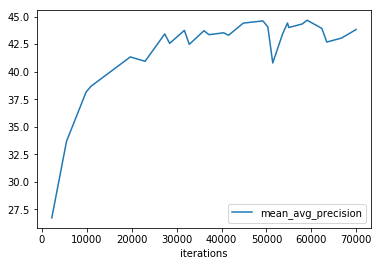

In [8]:
data.plot(x='iterations', y='mean_avg_precision')
plt.show()

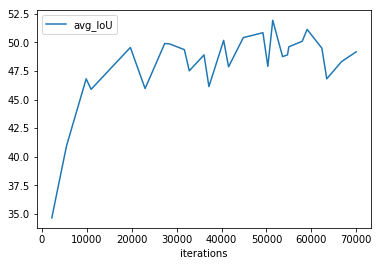

In [9]:
data.plot(x='iterations', y='avg_IoU')
plt.show()

In [10]:
CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run5_multi_gpu_lr0005_128bacth', 'yolov3-bdd100k_51418.weights')
#CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run1_newanchors', 'yolov3-bdd100k_51418.weights')

VIDEOS_DIRECTORY = '/media/dean/datastore1/datasets/BerkeleyDeepDrive/bdd100k/videos/val'
video_files = glob.glob(os.path.join(VIDEOS_DIRECTORY, '*.mov'))
VIDEO_FILE = video_files[np.random.randint(0, len(video_files))]
#VIDEO_FILE = '/media/dean/datastore/datasets/BerkeleyDeepDrive/bdd100k/videos/test/videos/f41d85d7-127effdb.mov'

TMP_FILE = os.path.splitext(VIDEO_FILE)[0]+'-rotated.mov'
FIXED_VIDEO_FILE = os.path.splitext(VIDEO_FILE)[0]+'-fixed.mov'
ANNOTATED_FILE = os.path.join('/home/dean/Desktop', os.path.splitext(VIDEO_FILE)[0]+'-annotated.mov')

if os.path.exists(FIXED_VIDEO_FILE):
    !cd $WORKING_DIRECTORY && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
else:
    !cd $WORKING_DIRECTORY && ffmpeg -i $VIDEO_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $TMP_FILE && ffmpeg -i  $TMP_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $FIXED_VIDEO_FILE && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
            

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

frame= 1211 fps= 71 q=-1.0 Lsize=   17181kB time=00:00:40.34 bitrate=3489.1kbits/s    
video:17166kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.088524%
[libx264 @ 0xfaa580] frame I:5     Avg QP:22.51  size:120781
[libx264 @ 0xfaa580] frame P:604   Avg QP:24.74  size: 23455
[libx264 @ 0xfaa580] frame B:602   Avg QP:29.23  size:  4662
[libx264 @ 0xfaa580] consecutive B-frames:  0.8% 98.4%  0.7%  0.0%
[libx264 @ 0xfaa580] mb I  I16..4:  6.6% 54.9% 38.6%
[libx264 @ 0xfaa580] mb P  I16..4:  1.5%  3.0%  1.2%  P16..4: 48.9% 19.5%  7.8%  0.0%  0.0%    skip:18.2%
[libx264 @ 0xfaa580] mb B  I16..4:  0.1%  0.1%  0.1%  B16..8: 47.9%  5.5%  0.6%  direct: 0.8%  skip:44.9%  L0:41.8% L1:48.6% BI: 9.6%
[libx264 @ 0xfaa580] 8x8 transform intra:52.9% inter:61.5%
[libx264 @ 0xfaa580] coded y,uvDC,uvAC intra: 59.3% 63.0% 17.0% inter: 17.2% 14.4% 2.5%
[libx264 @ 0xfaa580] i16 v,h,dc,p: 14% 40% 21% 25%
[libx264 @ 0xfaa580] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 14% 25% 29%  4%  6%

Done!
video file: /media/dean/datastore1/datasets/BerkeleyDeepDrive/bdd100k/videos/val/b7db31d1-06d2afc1-fixed.mov
Video stream: 1280 x 720 

FPS:0.0
Objects:


FPS:0.0
Objects:

traffic sign: 48% 
bus: 77% 
truck: 41% 
car: 100% 
car: 100% 
car: 98% 
car: 97% 
car: 97% 
car: 95% 
car: 82% 
car: 80% 
car: 74% 
car: 70% 
car: 61% 
car: 50% 
car: 44% 
car: 43% 
car: 42% 
car: 38% 
car: 32% 
car: 31% 

FPS:0.0
Objects:

traffic sign: 37% 
bus: 67% 
car: 100% 
car: 100% 
car: 97% 
car: 97% 
car: 91% 
car: 88% 
car: 73% 
car: 65% 
car: 61% 
car: 57% 
car: 55% 
car: 48% 
car: 48% 
car: 44% 
car: 43% 
car: 40% 
car: 36% 
car: 31% 
car: 31% 
car: 29% 
car: 27% 

FPS:33.1
Objects:

traffic sign: 25% 
bus: 73% 
truck: 59% 
car: 100% 
car: 100% 
car: 97% 
car: 95% 
car: 94% 
car: 94% 
car: 86% 
car: 80% 
car: 62% 
car: 57% 
car: 57% 
car: 53% 
car: 49% 
car: 44% 
car: 38% 
car: 31% 
car: 27% 
car: 26% 
car: 26% 
car: 26% 

FPS:36.5
Objects:

traffic sign: 47% 
bus: 81% 
car: 34% truck: 34% 
car: 


FPS:36.9
Objects:

traffic sign: 72% 
bus: 80% 
bus: 28% 
truck: 77% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 76% 
car: 73% 
car: 71% 
car: 69% 
car: 64% 
car: 44% 
car: 39% 
car: 29% 
car: 25% 

FPS:36.8
Objects:

traffic sign: 62% 
bus: 72% 
bus: 29% 
truck: 73% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 76% 
car: 73% 
car: 71% 
car: 70% 
car: 62% 
car: 38% 
car: 34% 
car: 32% 
car: 28% 
car: 28% 
car: 27% 
car: 27% 
car: 25% 

FPS:35.7
Objects:

traffic sign: 63% 
bus: 67% 
car: 28% bus: 37% 
truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 84% 
car: 76% 
car: 76% 
car: 69% 
car: 58% 
car: 45% 
car: 41% 
car: 40% 
car: 31% 
car: 29% 

FPS:27.6
Objects:

traffic sign: 54% 
bus: 58% 
truck: 26% bus: 34% 
truck: 55% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 98% 
car: 98% 
car: 84% 
car: 82% 
car: 76% 
car: 76% 
car: 60% 
car: 48% 
car: 47% 
car: 38% 
car: 34% 
car: 31% 
car: 30% 
c


FPS:30.6
Objects:

bus: 88% 
bus: 87% 
truck: 44% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 82% 
car: 80% 
car: 68% 
car: 66% 
car: 50% 
car: 44% 
car: 37% 
car: 37% 
car: 27% 
car: 27% 
car: 25% 

FPS:36.9
Objects:

bus: 95% 
bus: 87% 
truck: 51% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 89% 
car: 75% 
car: 72% 
car: 61% 
car: 58% 
car: 51% 
car: 46% 
car: 30% 
car: 26% 
car: 26% 

FPS:38.7
Objects:

traffic sign: 33% 
bus: 91% 
bus: 84% 
truck: 43% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 95% 
car: 75% 
car: 72% 
car: 60% 
car: 59% 
car: 57% 
car: 48% 
car: 44% 
car: 37% 
car: 34% 
car: 34% 

FPS:37.9
Objects:

bus: 85% 
bus: 84% 
truck: 32% 
truck: 46% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 94% 
car: 73% 
car: 66% 
car: 62% 
car: 57% 
car: 53% 
car: 48% 
car: 47% 
car: 43% 
car: 37% 
car: 31% 
car: 29% 

FPS:38.9
Objects:

traffic sign: 38% 
bus: 85% 
bus: 78% 
truck: 35% 
truck: 54% 
car: 100% 
car: 100% 
car: 


FPS:33.1
Objects:

traffic sign: 39% 
bus: 85% 
bus: 25% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 96% 
car: 92% 
car: 65% 
car: 58% 
car: 49% 
car: 48% 
car: 48% 
car: 45% 
car: 44% 
car: 42% 
car: 42% 
car: 30% 
car: 29% 
car: 28% 

FPS:39.6
Objects:

traffic sign: 46% 
bus: 83% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 96% 
car: 89% 
car: 55% 
car: 52% 
car: 48% 
car: 47% 
car: 45% 
car: 45% 
car: 41% 
car: 41% 
car: 41% 
car: 37% 
car: 31% 
car: 30% 
car: 30% 
car: 30% 
car: 29% 
car: 26% 

FPS:37.8
Objects:

traffic sign: 26% 
bus: 86% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 95% 
car: 91% 
car: 54% 
car: 53% 
car: 49% 
car: 49% 
car: 47% 
car: 47% 
car: 43% 
car: 42% 
car: 38% 
car: 38% 
car: 32% 
car: 30% 
car: 30% 
car: 26% 
car: 26% 

FPS:29.4
Objects:

traffic sign: 31% 
bus: 86% 
car: 26% bus: 28% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 94% 
car: 93% 
car: 60% 
car: 59% 
car: 55% 
car: 53% 
car: 52% 
car


FPS:36.5
Objects:

traffic sign: 38% 
bus: 82% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 91% 
car: 63% 
car: 62% 
car: 61% 
car: 57% 
car: 52% 
car: 41% 
car: 40% 
car: 34% 
car: 32% 
car: 29% 
car: 28% 
car: 27% 
car: 27% 

FPS:22.5
Objects:

traffic sign: 30% 
bus: 80% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 89% 
car: 74% 
car: 62% 
car: 52% 
car: 51% 
car: 45% 
car: 38% 
car: 38% 
car: 34% 
car: 34% 
car: 33% 
car: 32% 
car: 26% 
car: 26% 

FPS:27.0
Objects:

traffic sign: 40% 
bus: 81% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 90% 
car: 75% 
car: 42% 
car: 36% 
car: 34% 
car: 33% 
car: 31% 
car: 30% 
car: 30% 
car: 29% 
car: 28% 
car: 27% 
car: 26% 
car: 26% 
car: 25% 

FPS:34.5
Objects:

traffic sign: 32% 
bus: 88% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 90% 
car: 81% 
car: 48% 
car: 45% 
car: 37% 
car: 35% 
car: 34% 
car: 33% 
car: 33% 
car: 31% 
car: 30% 
car: 30% 
car: 3


FPS:27.4
Objects:

bus: 83% 
truck: 35% bus: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 94% 
car: 93% 
car: 80% 
car: 80% 
car: 75% 
car: 71% 
car: 71% 
car: 69% 
car: 51% 
car: 45% 
car: 43% 
car: 36% 
car: 35% 
car: 34% 
car: 32% 
car: 31% 
car: 26% 

FPS:33.3
Objects:

bus: 83% 
truck: 39% bus: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 93% 
car: 93% 
car: 90% 
car: 81% 
car: 72% 
car: 66% 
car: 57% 
car: 53% 
car: 48% 
car: 44% 
car: 43% 
car: 37% 
car: 37% 
car: 28% 
car: 27% 

FPS:24.4
Objects:

bus: 81% 
truck: 40% bus: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 92% 
car: 86% 
car: 84% 
car: 82% 
car: 75% 
car: 69% 
car: 64% 
car: 57% 
car: 47% 
car: 43% 
car: 41% 
car: 39% 
car: 35% 
car: 29% 
car: 28% 
car: 27% 
car: 27% 
car: 26% 
car: 25% 

FPS:36.9
Objects:

bus: 78% 
truck: 32% bus: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 93% 
car: 88% 
car: 78% 
car: 64% 
car: 63% 
car: 62% 
car: 60% 
car: 57% 



FPS:28.2
Objects:

bus: 72% 
car: 32% truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 78% 
car: 70% 
car: 69% 
car: 64% 
car: 62% 
car: 58% 
car: 57% 
car: 54% 
car: 44% 
car: 39% 
car: 39% 
car: 36% 
car: 35% 
car: 33% 
car: 31% 
car: 26% 

FPS:35.6
Objects:

bus: 69% 
car: 33% truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 78% 
car: 70% 
car: 66% 
car: 62% 
car: 60% 
car: 59% 
car: 53% 
car: 53% 
car: 53% 
car: 49% 
car: 43% 
car: 40% 
car: 30% 
car: 27% 

FPS:38.4
Objects:

bus: 62% 
car: 41% truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 72% 
car: 72% 
car: 69% 
car: 69% 
car: 68% 
car: 64% 
car: 49% 
car: 49% 
car: 43% 
car: 43% 
car: 38% 
car: 38% 
car: 26% 
car: 26% 

FPS:37.7
Objects:

bus: 61% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 77% 
car: 77% 
car: 77% 
car: 70% 
car: 65% 
car: 53% 
car: 47% 
car: 46% 
car: 44% 
car: 41% 
car: 38% 
car: 37% 
car: 35% 
car: 33% 
car: 28% 

FPS:39.2
Objects:

bus: 60% 
car: 57% truck: 26% 



FPS:36.7
Objects:

bus: 87% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 93% 
car: 91% 
car: 77% 
car: 76% 
car: 54% 
car: 52% 
car: 49% 
car: 43% 
car: 35% 
car: 35% 
car: 30% 
car: 28% 
car: 27% 
car: 26% 

FPS:28.8
Objects:

bus: 86% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 96% 
car: 89% 
car: 72% 
car: 64% 
car: 60% 
car: 48% 
car: 44% 
car: 42% 
car: 41% 
car: 28% 
car: 26% 
car: 26% 

FPS:38.6
Objects:

bus: 83% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 87% 
car: 63% 
car: 60% 
car: 53% 
car: 48% 
car: 43% 
car: 40% 
car: 32% 
car: 32% 
car: 30% 
car: 28% 
car: 28% 
car: 27% 
car: 25% 

FPS:36.8
Objects:

bus: 80% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 90% 
car: 74% 
car: 57% 
car: 53% 
car: 49% 
car: 46% 
car: 45% 
car: 39% 
car: 37% 
car: 37% 
car: 37% 
car: 33% 
car: 33% 
car: 31% 
car: 30% 
car: 28% 
car: 28% 

FPS:36.5
Objects:

bus: 81% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 89% 
car: 67% 
car: 61% 
car: 55% 



FPS:36.2
Objects:

bus: 76% 
bus: 75% 
bus: 55% 
car: 26% truck: 39% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 89% 
car: 78% 
car: 69% 
car: 54% 
car: 53% 
car: 41% 
car: 35% 
car: 30% 
car: 30% 

FPS:27.5
Objects:

truck: 30% bus: 84% 
bus: 72% 
bus: 68% 
car: 31% truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 94% 
car: 83% 
car: 77% 
car: 74% 
car: 73% 
car: 50% 
car: 41% 
car: 39% 
car: 32% 
car: 31% 

FPS:38.5
Objects:

bus: 80% 
bus: 78% 
bus: 66% 
truck: 38% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 93% 
car: 81% 
car: 74% 
car: 73% 
car: 69% 
car: 45% 
car: 39% 
car: 34% 
car: 29% 
car: 25% 

FPS:38.8
Objects:

bus: 70% 
bus: 69% 
truck: 47% bus: 38% 
truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 87% 
car: 72% 
car: 62% 
car: 57% 
car: 53% 
car: 40% 
car: 37% 
car: 37% 
car: 32% 

FPS:38.8
Objects:

bus: 65% 
truck: 27% bus: 55% 
truck: 43% bus: 54% 
truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 


FPS:34.7
Objects:

bus: 72% 
truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 86% 
car: 77% 
car: 74% 
car: 65% 
car: 57% 
car: 51% 
car: 42% 
car: 37% 
car: 26% 

FPS:25.6
Objects:

bus: 79% 
truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 94% 
car: 93% 
car: 90% 
car: 79% 
car: 66% 
car: 56% 
car: 53% 
car: 45% 
car: 43% 
car: 40% 
car: 38% 
car: 27% 
car: 27% 

FPS:30.3
Objects:

bus: 73% 
truck: 37% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 91% 
car: 89% 
car: 80% 
car: 62% 
car: 59% 
car: 55% 
car: 55% 
car: 45% 
car: 40% 
car: 37% 
car: 36% 
car: 36% 
car: 30% 
car: 27% 

FPS:29.3
Objects:

bus: 74% 
truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 95% 
car: 90% 
car: 87% 
car: 77% 
car: 58% 
car: 54% 
car: 49% 
car: 46% 
car: 44% 
car: 44% 
car: 41% 
car: 35% 
car: 30% 
car: 28% 

FPS:32.1
Objects:

bus: 74% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 89% 
car: 88% 
car: 65% 
car: 63% 
car: 60% 


FPS:33.8
Objects:

bus: 64% 
truck: 26% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 93% 
car: 91% 
car: 84% 
car: 72% 
car: 68% 
car: 68% 
car: 65% 
car: 59% 
car: 37% 
car: 30% 
car: 26% 

FPS:26.5
Objects:

bus: 67% 
truck: 34% 
truck: 29% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 88% 
car: 87% 
car: 84% 
car: 73% 
car: 66% 
car: 63% 
car: 62% 
car: 56% 
car: 32% 
car: 31% 

FPS:26.1
Objects:

bus: 64% 
truck: 40% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 92% 
car: 86% 
car: 83% 
car: 67% 
car: 66% 
car: 61% 
car: 60% 
car: 59% 
car: 35% 

FPS:28.9
Objects:

bus: 62% 
truck: 37% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 98% 
car: 96% 
car: 85% 
car: 84% 
car: 73% 
car: 66% 
car: 60% 
car: 59% 
car: 50% 
car: 48% 
car: 33% 
car: 25% 

FPS:27.1
Objects:

bus: 64% 
truck: 32% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 89% 
car: 80% 
car: 79% 
car: 76% 
car: 70% 
car: 65% 
car: 52% 
ca


FPS:27.6
Objects:

bus: 81% 
truck: 49% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 96% 
car: 90% 
car: 89% 
car: 84% 
car: 77% 
car: 73% 
car: 66% 
car: 55% 
car: 54% 
car: 29% 

FPS:26.2
Objects:

bus: 83% 
truck: 47% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 96% 
car: 95% 
car: 91% 
car: 89% 
car: 89% 
car: 84% 
car: 72% 
car: 67% 
car: 62% 
car: 52% 

FPS:30.7
Objects:

bus: 76% 
truck: 39% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 95% 
car: 92% 
car: 90% 
car: 86% 
car: 84% 
car: 78% 
car: 65% 
car: 65% 
car: 55% 
car: 27% 

FPS:27.7
Objects:

bus: 77% 
truck: 40% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 96% 
car: 95% 
car: 93% 
car: 89% 
car: 88% 
car: 84% 
car: 81% 
car: 72% 
car: 63% 
car: 56% 

FPS:29.2
Objects:

bus: 76% 
truck: 45% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 94% 
car: 91% 
car: 88% 
car: 86% 
car: 82% 
ca


FPS:34.1
Objects:

bus: 84% 
truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 97% 
car: 93% 
car: 78% 
car: 62% 
car: 46% 
car: 45% 
car: 40% 
car: 34% 

FPS:26.2
Objects:

bus: 84% 
truck: 28% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 91% 
car: 86% 
car: 72% 
car: 45% 
car: 40% 
car: 30% 

FPS:34.3
Objects:

bus: 87% 
truck: 26% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 93% 
car: 85% 
car: 62% 
car: 48% 
car: 30% 

FPS:30.0
Objects:

bus: 86% 
truck: 29% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 96% 
car: 93% 
car: 80% 
car: 56% 
car: 49% 
car: 28% 

FPS:26.7
Objects:

bus: 86% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 92% 
car: 77% 
car: 60% 
car: 58% 

FPS:31.5
Objects:

bus: 88% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 94% 
car: 85% 
car: 70% 
car: 67% 
car: 56% 

FPS:33.8
Objects:

bus: 88% 


FPS:25.5
Objects:

traffic sign: 77% 
bus: 81% 
truck: 46% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 98% 
car: 82% 
car: 72% 
car: 27% 
car: 26% 

FPS:34.2
Objects:

traffic sign: 62% 
bus: 83% 
truck: 47% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 96% 
car: 96% 
car: 85% 
car: 73% 
car: 67% 
car: 38% 

FPS:24.3
Objects:

traffic sign: 35% 
bus: 82% 
truck: 43% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 92% 
car: 86% 
car: 85% 
car: 62% 
car: 37% 

FPS:28.1
Objects:

traffic sign: 67% 
bus: 78% 
truck: 50% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 98% 
car: 97% 
car: 93% 
car: 78% 
car: 64% 

FPS:30.6
Objects:

traffic sign: 75% 
bus: 76% 
truck: 51% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 94% 
car: 78% 
car: 56% 

FPS:31.1
Objects:

traffic sign: 69% 
bus: 74% 
truck: 52% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car


FPS:31.3
Objects:

bus: 62% 
truck: 47% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 95% 
car: 60% 
car: 56% 
car: 51% 
car: 46% 
car: 39% 

FPS:32.1
Objects:

bus: 59% 
truck: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 93% 
car: 83% 
car: 67% 
car: 56% 
car: 42% 
car: 38% 
car: 33% 
car: 28% 

FPS:28.8
Objects:

bus: 55% 
truck: 52% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 94% 
car: 87% 
car: 69% 
car: 66% 
car: 49% 
car: 38% 

FPS:27.3
Objects:

bus: 67% 
truck: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 81% 
car: 75% 
car: 64% 
car: 37% 
car: 36% 
car: 34% 
car: 27% 

FPS:31.9
Objects:

bus: 65% 
truck: 58% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 77% 
car: 53% 
car: 47% 
car: 46% 
car: 32% 
car: 32% 

FPS:26.9
Objects:

bus: 63% 
truck: 45% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 95% 
car: 62% 
car: 55% 
car: 47% 
car: 43% 
car: 30% 

FPS:26.4


FPS:35.1
Objects:

bus: 60% 
truck: 64% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 93% 
car: 83% 
car: 82% 
car: 69% 
car: 50% 
car: 36% 

FPS:26.7
Objects:

bus: 67% 
truck: 63% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 95% 
car: 86% 
car: 83% 
car: 51% 
car: 44% 
car: 42% 

FPS:25.8
Objects:

bus: 55% 
truck: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 82% 
car: 79% 
car: 71% 
car: 63% 
car: 37% 

FPS:30.7
Objects:

bus: 58% 
truck: 36% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 93% 
car: 88% 
car: 71% 
car: 63% 
car: 49% 
car: 29% 

FPS:34.6
Objects:

bus: 59% 
truck: 43% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 94% 
car: 93% 
car: 87% 
car: 78% 
car: 72% 
car: 63% 
car: 36% 
car: 31% 

FPS:26.3
Objects:

bus: 63% 
truck: 60% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 93% 
car: 91% 
car: 68% 
car: 63% 
car: 60% 
car: 33% 
car: 26% 

FPS:29.5
Objects:

bus: 68% 
truck: 75% 
car: 100%


FPS:24.9
Objects:

bus: 53% 
bus: 39% 
truck: 38% 
truck: 62% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 72% 
car: 71% 
car: 71% 
car: 68% 
car: 56% 
car: 50% 
car: 39% 

FPS:35.7
Objects:

bus: 48% 
bus: 37% 
truck: 30% 
truck: 54% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 92% 
car: 67% 
car: 66% 
car: 58% 
car: 50% 
car: 44% 
car: 37% 

FPS:26.9
Objects:

truck: 32% bus: 47% 
bus: 47% 
truck: 57% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 92% 
car: 66% 
car: 62% 
car: 59% 
car: 54% 
car: 33% 

FPS:26.0
Objects:

truck: 29% bus: 57% 
bus: 43% 
truck: 65% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 93% 
car: 65% 
car: 64% 
car: 51% 
car: 44% 

FPS:29.9
Objects:

bus: 74% 
bus: 50% 
truck: 72% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 92% 
car: 78% 
car: 66% 
car: 52% 
car: 51% 
car: 43% 

FPS:34.5
Objects:

bus: 57% 
bus: 44% 
truck: 52% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 91% 
car: 81% 
car: 59% 
car: 57% 
car: 53% 
car: 42% 
car: 41% 

FPS:30.


FPS:29.9
Objects:

bus: 61% 
truck: 53% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 58% 
car: 53% 
car: 43% 
car: 41% 
car: 36% 
car: 29% 

FPS:34.2
Objects:

bus: 73% 
truck: 57% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 71% 
car: 65% 
car: 60% 
car: 56% 
car: 44% 

FPS:26.3
Objects:

bus: 73% 
truck: 59% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 86% 
car: 70% 
car: 66% 
car: 61% 
car: 53% 

FPS:28.4
Objects:

bus: 73% 
truck: 57% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 63% 
car: 62% 
car: 57% 
car: 46% 

FPS:24.4
Objects:

bus: 73% 
truck: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 85% 
car: 79% 
car: 63% 
car: 59% 
car: 55% 

FPS:34.9
Objects:

bus: 71% 
truck: 39% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 90% 
car: 87% 
car: 68% 
car: 64% 
car: 62% 
car: 61% 

FPS:25.3
Objects:

bus: 65% 
truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 75% 
car: 75% 
car: 70% 
car: 69% 
car: 44% 
car: 40% 

FPS:33.0
Objects:

bus:


FPS:25.6
Objects:

bus: 33% 
truck: 54% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 64% 
car: 60% 
car: 57% 
car: 48% 

FPS:27.0
Objects:

traffic sign: 29% 
bus: 48% 
truck: 60% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 76% 
car: 72% 
car: 68% 
car: 63% 
car: 57% 
car: 39% 

FPS:23.6
Objects:

bus: 56% 
truck: 50% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 81% 
car: 68% 
car: 66% 
car: 52% 
car: 51% 
car: 44% 

FPS:31.8
Objects:

bus: 76% 
truck: 47% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 84% 
car: 66% 
car: 62% 
car: 60% 
car: 47% 
car: 28% 

FPS:27.4
Objects:

bus: 72% 
truck: 60% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 82% 
car: 65% 
car: 62% 
car: 57% 
car: 48% 
car: 43% 

FPS:31.3
Objects:

bus: 57% 
truck: 44% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 91% 
car: 67% 
car: 58% 
car: 53% 
car: 44% 
car: 35% 

FPS:33.4
Objects:

bus: 48% 
truck: 61% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 73% 
car: 65% 
car: 53% 


FPS:30.5
Objects:

bus: 61% 
truck: 62% 
car: 72% truck: 43% 
truck: 39% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 94% 
car: 49% 
car: 43% 
car: 39% 
car: 38% 
car: 28% 

FPS:32.4
Objects:

traffic sign: 33% 
bus: 66% 
truck: 51% 
truck: 42% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 94% 
car: 88% 
car: 65% 
car: 51% 
car: 37% 
car: 32% 
car: 26% 

FPS:26.1
Objects:

traffic sign: 30% 
bus: 67% 
truck: 33% 
truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 83% 
car: 50% 
car: 49% 
car: 37% 
car: 32% 

FPS:29.5
Objects:

bus: 64% 
truck: 51% 
truck: 35% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 72% 
car: 69% 
car: 52% 
car: 41% 

FPS:29.0
Objects:

traffic sign: 27% 
bus: 67% 
truck: 51% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 65% 
car: 61% 
car: 59% 
car: 54% 
car: 34% 
car: 29% 

FPS:33.9
Objects:

bus: 74% 
truck: 57% 
truck: 38% 
car: 100% 
car: 100% 
car: 100% 
ca


FPS:28.6
Objects:

bus: 87% 
truck: 54% 
truck: 38% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 84% 
car: 70% 
car: 53% 
car: 42% 
car: 28% 
car: 27% 

FPS:29.7
Objects:

bus: 88% 
truck: 53% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 89% 
car: 88% 
car: 85% 
car: 77% 
car: 57% 
car: 43% 
car: 37% 

FPS:26.1
Objects:

bus: 85% 
truck: 54% 
truck: 26% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 94% 
car: 93% 
car: 89% 
car: 83% 
car: 53% 
car: 42% 

FPS:29.7
Objects:

bus: 88% 
truck: 51% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 94% 
car: 92% 
car: 90% 
car: 72% 
car: 42% 
car: 41% 
car: 26% 

FPS:23.4
Objects:

bus: 92% 
truck: 25% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 93% 
car: 92% 
car: 90% 
car: 86% 
car: 86% 
car: 63% 
car: 37% 
car: 26% 
car: 26% 

FPS:24.6
Objects:

bus: 92% 
truck: 36% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 94% 
car: 94% 
car: 92% 
car: 90% 
car: 63% 
car: 44% 
car: 37% 
ca


FPS:24.9
Objects:

bus: 80% 
truck: 59% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 94% 
car: 92% 
car: 70% 
car: 67% 
car: 45% 
car: 37% 

FPS:36.3
Objects:

bus: 92% 
truck: 62% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 94% 
car: 83% 
car: 69% 
car: 65% 
car: 39% 
car: 27% 

FPS:26.1
Objects:

bus: 94% 
truck: 52% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 94% 
car: 89% 
car: 75% 
car: 55% 
car: 37% 
car: 33% 

FPS:25.5
Objects:

bus: 95% 
truck: 68% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 92% 
car: 64% 
car: 58% 
car: 50% 
car: 27% 
car: 26% 

FPS:27.1
Objects:

bus: 96% 
truck: 52% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 67% 
car: 65% 
car: 55% 
car: 40% 
car: 29% 

FPS:33.0
Objects:

bus: 96% 
truck: 58% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 72% 
car: 63% 
car: 54% 
car: 52% 
car: 26% 

FPS:26.6
Objects:

bus: 95% 
truck: 61% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 80% 
car: 74% 
car: 60% 
car: 49% 



FPS:34.6
Objects:

bus: 93% 
truck: 65% 
truck: 49% 
car: 36% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 80% 
car: 67% 
car: 57% 
car: 44% 
car: 26% 

FPS:25.0
Objects:

bus: 90% 
truck: 55% 
truck: 48% 
car: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 79% 
car: 54% 
car: 46% 
car: 44% 

FPS:23.1
Objects:

bus: 93% 
truck: 49% 
car: 34% 
truck: 38% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 78% 
car: 41% 
car: 41% 
car: 40% 
car: 29% 

FPS:32.8
Objects:

bus: 92% 
truck: 53% 
car: 49% truck: 51% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 97% 
car: 80% 
car: 57% 
car: 42% 
car: 42% 
car: 37% 
car: 28% 

FPS:33.3
Objects:

bus: 93% 
truck: 66% 
truck: 30% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 84% 
car: 80% 
car: 42% 
car: 39% 
car: 32% 
car: 31% 

FPS:26.5
Objects:

bus: 94% 
truck: 61% 
car: 53% truck: 48% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 95% 
car: 76% 
car: 49% 
car: 40% 
car: 27% 
car: 26% 

FPS


FPS:32.2
Objects:

bus: 97% 
bus: 87% 
truck: 38% 
truck: 34% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 82% 
car: 77% 
car: 55% 
car: 53% 
car: 52% 
car: 32% 

FPS:25.4
Objects:

bus: 97% 
bus: 87% 
truck: 48% 
truck: 30% 
car: 100% 
car: 100% 
car: 99% 
car: 91% 
car: 79% 
car: 62% 
car: 59% 
car: 48% 
car: 38% 
car: 36% 
car: 26% 

FPS:24.3
Objects:

bus: 97% 
bus: 84% 
truck: 45% 
truck: 27% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 84% 
car: 51% 
car: 49% 
car: 44% 
car: 40% 
car: 35% 

FPS:30.1
Objects:

bus: 96% 
bus: 81% 
truck: 44% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 84% 
car: 57% 
car: 49% 
car: 48% 
car: 31% 

FPS:34.4
Objects:

bus: 95% 
bus: 68% 
truck: 42% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 95% 
car: 63% 
car: 48% 
car: 44% 
car: 35% 
car: 31% 
car: 30% 

FPS:25.7
Objects:

bus: 95% 
bus: 42% 
truck: 55% 
truck: 28% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 53% 
car: 52% 
car: 44% 
car: 36% 
car: 33% 

FPS:29.8
Objects:


FPS:29.4
Objects:

bus: 92% 
truck: 79% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 81% 
car: 39% 
car: 38% 
car: 38% 
car: 32% 
car: 30% 
car: 30% 
car: 27% 

FPS:26.1
Objects:

bus: 89% 
truck: 73% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 83% 
car: 42% 
car: 37% 
car: 36% 
car: 33% 
car: 30% 

FPS:34.9
Objects:

bus: 89% 
truck: 54% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 71% 
car: 59% 
car: 43% 
car: 43% 
car: 35% 
car: 35% 
car: 33% 

FPS:25.1
Objects:

bus: 89% 
truck: 67% 
car: 100% 
car: 100% 
car: 99% 
car: 90% 
car: 79% 
car: 57% 
car: 45% 
car: 42% 
car: 42% 
car: 38% 
car: 29% 
car: 27% 

FPS:29.1
Objects:

bus: 87% 
truck: 52% 
car: 100% 
car: 100% 
car: 99% 
car: 91% 
car: 67% 
car: 57% 
car: 57% 
car: 46% 
car: 44% 
car: 42% 
car: 34% 
car: 32% 
car: 29% 
car: 26% 

FPS:27.7
Objects:

bus: 89% 
truck: 78% 
car: 100% 
car: 100% 
car: 99% 
car: 94% 
car: 86% 
car: 61% 
car: 48% 
car: 47% 
car: 44% 
car: 41% 
car: 31% 
car: 30% 
car: 29% 
car: 26% 

FPS:2


FPS:30.8
Objects:

bus: 98% 
truck: 62% 
car: 100% 
car: 100% 
car: 100% 
car: 94% 
car: 94% 
car: 60% 
car: 59% 
car: 59% 
car: 45% 
car: 45% 
car: 29% 
car: 27% 

FPS:26.0
Objects:

bus: 98% 
truck: 46% 
car: 100% 
car: 100% 
car: 100% 
car: 93% 
car: 85% 
car: 63% 
car: 59% 
car: 53% 
car: 45% 
car: 43% 
car: 36% 
car: 29% 
car: 25% 

FPS:25.5
Objects:

bus: 98% 
truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 93% 
car: 78% 
car: 68% 
car: 59% 
car: 47% 
car: 44% 
car: 37% 
car: 32% 
car: 29% 
car: 28% 

FPS:27.3
Objects:

bus: 98% 
truck: 42% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 88% 
car: 56% 
car: 52% 
car: 46% 
car: 40% 
car: 39% 
car: 36% 
car: 32% 
car: 30% 
car: 29% 
car: 28% 

FPS:33.0
Objects:

bus: 98% 
truck: 34% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 92% 
car: 58% 
car: 47% 
car: 45% 
car: 44% 
car: 44% 
car: 42% 
car: 36% 
car: 34% 
car: 28% 
car: 26% 

FPS:25.5
Objects:

bus: 99% 
truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 91% 
ca


FPS:31.1
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 57% 
car: 55% 
car: 52% 
car: 49% 
car: 36% 
car: 32% 
car: 25% 

FPS:28.6
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 68% 
car: 57% 
car: 57% 
car: 46% 
car: 37% 
car: 30% 
car: 26% 

FPS:25.5
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 58% 
car: 55% 
car: 36% 
car: 35% 
car: 27% 
car: 27% 
car: 26% 

FPS:28.0
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 68% 
car: 66% 
car: 55% 
car: 47% 
car: 36% 
car: 34% 
car: 31% 
car: 26% 

FPS:25.2
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 68% 
car: 65% 
car: 52% 
car: 50% 
car: 36% 
car: 29% 
car: 26% 

FPS:33.2
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 74% 
car: 67% 
car: 57% 
car: 44% 
car: 43% 
car: 39% 

FPS:28.2
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 63% 
car: 55% 
car: 55% 
car: 53% 
car: 36% 
car: 31% 
car


FPS:30.5
Objects:

bus: 99% 
truck: 57% 
car: 56% 
car: 100% 
car: 99% 
car: 97% 
car: 94% 
car: 94% 
car: 89% 
car: 89% 
car: 81% 
car: 48% 
car: 44% 
car: 35% 
car: 33% 
car: 31% 
car: 29% 
car: 26% 

FPS:33.3
Objects:

bus: 99% 
truck: 51% 
car: 56% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 94% 
car: 92% 
car: 81% 
car: 72% 
car: 40% 
car: 40% 
car: 36% 
car: 35% 
car: 27% 
car: 27% 

FPS:29.0
Objects:

bus: 99% 
truck: 61% 
car: 63% 
car: 100% 
car: 100% 
car: 96% 
car: 95% 
car: 94% 
car: 94% 
car: 90% 
car: 80% 
car: 34% 
car: 34% 
car: 31% 
car: 26% 

FPS:27.7
Objects:

bus: 99% 
truck: 33% 
car: 54% 
car: 100% 
car: 100% 
car: 98% 
car: 96% 
car: 94% 
car: 93% 
car: 89% 
car: 83% 
car: 34% 
car: 33% 
car: 31% 
car: 28% 

FPS:31.1
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 98% 
car: 95% 
car: 89% 
car: 87% 
car: 82% 
car: 81% 
car: 77% 
car: 44% 
car: 39% 
car: 36% 
car: 34% 
car: 33% 
car: 26% 

FPS:25.4
Objects:

bus: 94% 
truck: 30% 
car: 100% 
car: 100% 
car: 98% 


FPS:27.6
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 83% 
car: 82% 
car: 81% 
car: 77% 
car: 74% 
car: 71% 
car: 62% 
car: 53% 
car: 40% 
car: 31% 

FPS:30.1
Objects:

bus: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 86% 
car: 76% 
car: 76% 
car: 74% 
car: 73% 
car: 71% 
car: 65% 
car: 31% 
car: 30% 

FPS:28.0
Objects:

bus: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 69% 
car: 68% 
car: 68% 
car: 67% 
car: 67% 
car: 66% 
car: 66% 
car: 29% 
car: 27% 

FPS:31.6
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 79% 
car: 77% 
car: 69% 
car: 69% 
car: 68% 
car: 67% 
car: 64% 
car: 45% 
car: 40% 
car: 39% 
car: 29% 

FPS:25.3
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 93% 
car: 88% 
car: 85% 
car: 83% 
car: 71% 
car: 67% 
car: 66% 
car: 66% 
car: 31% 
car: 31% 
car: 27% 

FPS:28.8
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 90% 
car: 84% 
car: 82% 
car: 70% 
car: 69% 
car: 68% 
car: 65% 
car: 36% 
car: 36% 
car: 32% 
car: 28% 
Stream closed.
input vid

In [11]:
CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run5_multi_gpu_lr0005_128bacth', 'yolov3-bdd100k_59076.weights')
WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet/darknet_evaluate/'
if os.path.exists(FIXED_VIDEO_FILE):
    !cd $WORKING_DIRECTORY && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
else:
    !cd $WORKING_DIRECTORY && ffmpeg -i $VIDEO_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $TMP_FILE && ffmpeg -i  $TMP_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $FIXED_VIDEO_FILE && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
            

Demo
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
 


FPS:30.3
Objects:

traffic sign: 41% 
bus: 95% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 95% 
car: 93% 
car: 88% 
car: 86% 
car: 78% 
car: 74% 
car: 72% 
car: 72% 
car: 60% 
car: 52% 
car: 50% 
car: 49% 
car: 40% 
car: 35% 
car: 34% 
car: 32% 
car: 31% 
car: 31% 
car: 30% 
car: 28% 
car: 28% 
car: 27% 
car: 27% 
car: 26% 

FPS:30.4
Objects:

traffic sign: 32% 
bus: 95% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 93% 
car: 85% 
car: 82% 
car: 66% 
car: 66% 
car: 58% 
car: 52% 
car: 51% 
car: 50% 
car: 44% 
car: 43% 
car: 41% 
car: 40% 
car: 35% 
car: 32% 
car: 32% 
car: 31% 
car: 29% 
car: 26% 

FPS:30.8
Objects:

traffic sign: 54% 
traffic sign: 47% 
bus: 95% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 94% 
car: 87% 
car: 84% 
car: 81% 
car: 71% 
car: 70% 
car: 69% 
car: 69% 
car: 62% 
car: 55% 
car: 50% 
car: 42% 
car: 42% 
car: 36% 
car: 31% 
car: 30% 
car: 28% 
car: 26% 

FPS:28.5
Objects:

traffic s


FPS:34.2
Objects:

traffic sign: 61% 
bus: 95% 
car: 32% truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 93% 
car: 86% 
car: 81% 
car: 78% 
car: 66% 
car: 65% 
car: 60% 
car: 54% 
car: 50% 
car: 50% 
car: 48% 
car: 47% 
car: 45% 
car: 41% 
car: 40% 
car: 36% 
car: 33% 
car: 32% 
car: 31% 
car: 29% 
car: 27% 
car: 26% 
car: 25% 
car: 25% 

FPS:36.9
Objects:

traffic sign: 69% 
bus: 94% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 93% 
car: 93% 
car: 88% 
car: 83% 
car: 83% 
car: 76% 
car: 58% 
car: 54% 
car: 51% 
car: 51% 
car: 49% 
car: 48% 
car: 46% 
car: 46% 
car: 44% 
car: 42% 
car: 39% 
car: 38% 
car: 35% 
car: 34% 
car: 32% 
car: 27% 

FPS:38.2
Objects:

traffic sign: 62% 
bus: 95% 
car: 30% truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 92% 
car: 89% 
car: 84% 
car: 82% 
car: 78% 
car: 60% 
car: 59% 
car: 53% 
car: 48% 
car: 41% 
car: 38% 
car: 36% 
car: 33% 
car: 31% 
ca


FPS:38.1
Objects:

traffic sign: 71% 
traffic sign: 63% 
bus: 98% 
bus: 93% 
bus: 30% 
bus: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 84% 
car: 72% 
car: 68% 
car: 68% 
car: 62% 
car: 60% 
car: 56% 
car: 54% 
car: 54% 
car: 54% 
car: 50% 
car: 50% 
car: 50% 
car: 49% 
car: 33% 
car: 32% 
car: 32% 
car: 29% 

FPS:37.2
Objects:

traffic sign: 68% 
traffic sign: 57% 
bus: 98% 
car: 27% bus: 52% 
bus: 46% 
bus: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 91% 
car: 76% 
car: 72% 
car: 70% 
car: 69% 
car: 63% 
car: 63% 
car: 61% 
car: 58% 
car: 53% 
car: 44% 
car: 43% 
car: 37% 
car: 34% 
car: 30% 
car: 29% 
car: 29% 

FPS:34.8
Objects:

traffic sign: 59% 
traffic sign: 54% 
bus: 98% 
bus: 74% 
bus: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 90% 
car: 76% 
car: 75% 
car: 74% 
car: 71% 
car: 69% 
car: 67% 
car: 64% 
car: 48% 
car: 43% 
car: 42% 
car: 38% 
car: 37% 
car: 35% 
car: 31% 
car: 25% 

FPS:37.7
Objects:

traffic sign: 56


FPS:36.7
Objects:

traffic sign: 59% 
bus: 82% 
bus: 54% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 86% 
car: 67% 
car: 67% 
car: 65% 
car: 60% 
car: 57% 
car: 57% 
car: 55% 
car: 54% 
car: 52% 
car: 51% 
car: 51% 
car: 51% 
car: 36% 
car: 32% 
car: 31% 

FPS:37.9
Objects:

traffic sign: 48% 
bus: 78% 
bus: 53% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 87% 
car: 72% 
car: 72% 
car: 66% 
car: 65% 
car: 64% 
car: 57% 
car: 54% 
car: 53% 
car: 53% 
car: 51% 
car: 46% 
car: 44% 
car: 42% 
car: 38% 
car: 36% 
car: 26% 

FPS:36.3
Objects:

traffic sign: 49% 
bus: 83% 
bus: 43% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 84% 
car: 73% 
car: 70% 
car: 69% 
car: 64% 
car: 63% 
car: 60% 
car: 52% 
car: 50% 
car: 48% 
car: 48% 
car: 47% 
car: 47% 
car: 43% 
car: 42% 
car: 41% 
car: 37% 
car: 30% 
car: 30% 
car: 29% 
car: 28% 

FPS:31.6
Objects:

bus: 90% 
bus: 51% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
c


FPS:34.4
Objects:

traffic sign: 63% 
bus: 97% 
bus: 53% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 87% 
car: 81% 
car: 72% 
car: 66% 
car: 64% 
car: 56% 
car: 55% 
car: 53% 
car: 52% 
car: 51% 
car: 45% 
car: 45% 
car: 44% 
car: 42% 
car: 42% 
car: 38% 
car: 37% 
car: 37% 
car: 37% 
car: 25% 

FPS:35.5
Objects:

traffic sign: 56% 
traffic sign: 30% 
bus: 97% 
bus: 55% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 89% 
car: 82% 
car: 80% 
car: 73% 
car: 69% 
car: 67% 
car: 61% 
car: 59% 
car: 52% 
car: 51% 
car: 48% 
car: 48% 
car: 40% 
car: 38% 
car: 35% 
car: 34% 
car: 30% 
car: 29% 
car: 27% 

FPS:37.2
Objects:

traffic sign: 75% 
traffic sign: 27% 
bus: 97% 
bus: 44% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 89% 
car: 85% 
car: 83% 
car: 73% 
car: 69% 
car: 68% 
car: 63% 
car: 62% 
car: 54% 
car: 53% 
car: 46% 
car: 42% 
car: 40% 
car: 40% 
car: 39% 
car: 34% 
car: 32% 
car


FPS:38.1
Objects:

traffic sign: 63% 
bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 70% 
car: 68% 
car: 68% 
car: 67% 
car: 63% 
car: 59% 
car: 58% 
car: 57% 
car: 54% 
car: 53% 
car: 48% 
car: 47% 
car: 41% 
car: 40% 
car: 37% 
car: 37% 
car: 36% 
car: 35% 
car: 33% 

FPS:29.0
Objects:

traffic sign: 69% 
bus: 99% 
car: 34% bus: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 83% 
car: 74% 
car: 69% 
car: 68% 
car: 68% 
car: 66% 
car: 65% 
car: 64% 
car: 58% 
car: 54% 
car: 52% 
car: 50% 
car: 47% 
car: 45% 
car: 42% 
car: 41% 
car: 40% 
car: 25% 

FPS:38.6
Objects:

traffic sign: 45% 
bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 81% 
car: 75% 
car: 73% 
car: 72% 
car: 72% 
car: 71% 
car: 66% 
car: 63% 
car: 63% 
car: 59% 
car: 49% 
car: 45% 
car: 40% 
car: 39% 
car: 39% 
car: 37% 
car: 36% 
car: 32% 
car: 28% 
car: 26% 
car: 25% 

FPS:33.3
Objects:

bus: 99% 
bus:


FPS:34.3
Objects:

bus: 98% 
car: 27% bus: 39% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 91% 
car: 82% 
car: 80% 
car: 80% 
car: 68% 
car: 68% 
car: 67% 
car: 67% 
car: 63% 
car: 61% 
car: 58% 
car: 58% 
car: 56% 
car: 44% 
car: 40% 
car: 35% 
car: 32% 
car: 27% 
car: 27% 

FPS:37.2
Objects:

bus: 98% 
car: 31% bus: 40% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 95% 
car: 83% 
car: 82% 
car: 78% 
car: 75% 
car: 74% 
car: 73% 
car: 71% 
car: 71% 
car: 68% 
car: 68% 
car: 65% 
car: 62% 
car: 58% 
car: 42% 
car: 40% 
car: 36% 
car: 32% 
car: 28% 
car: 28% 
car: 26% 

FPS:38.3
Objects:

bus: 97% 
car: 35% bus: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 94% 
car: 84% 
car: 80% 
car: 74% 
car: 73% 
car: 71% 
car: 69% 
car: 69% 
car: 65% 
car: 64% 
car: 60% 
car: 57% 
car: 57% 
car: 49% 
car: 44% 
car: 43% 
car: 42% 
car: 39% 
car: 30% 
car: 28% 
car: 27% 
car: 25% 

FPS:32.5
Objects:

bus: 97% 
bus: 33% 
car: 38% bus: 30% 
car: 10


FPS:27.7
Objects:

bus: 92% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 86% 
car: 85% 
car: 78% 
car: 77% 
car: 75% 
car: 73% 
car: 66% 
car: 63% 
car: 59% 
car: 58% 
car: 54% 
car: 52% 
car: 51% 
car: 51% 
car: 46% 
car: 35% 
car: 33% 
car: 31% 

FPS:25.7
Objects:

bus: 89% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 88% 
car: 83% 
car: 81% 
car: 78% 
car: 75% 
car: 74% 
car: 74% 
car: 66% 
car: 62% 
car: 60% 
car: 59% 
car: 58% 
car: 53% 
car: 49% 
car: 49% 
car: 44% 
car: 42% 
car: 34% 
car: 30% 
car: 27% 
car: 26% 

FPS:30.3
Objects:

bus: 92% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 84% 
car: 82% 
car: 78% 
car: 75% 
car: 74% 
car: 74% 
car: 73% 
car: 72% 
car: 65% 
car: 61% 
car: 58% 
car: 54% 
car: 54% 
car: 50% 
car: 49% 
car: 48% 
car: 38% 
car: 37% 
car: 32% 
car: 31% 

FPS:30.9
Objects:

bus: 91% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 81% 
car: 81% 
car: 80% 
car: 77% 
car: 75% 
car: 72% 
car: 71% 
car: 65% 
car: 64% 
car: 62% 
car: 60% 
car: 57% 
ca


FPS:30.1
Objects:

bus: 99% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 86% 
car: 83% 
car: 78% 
car: 78% 
car: 74% 
car: 69% 
car: 56% 
car: 46% 
car: 44% 
car: 41% 
car: 41% 
car: 40% 
car: 40% 
car: 36% 
car: 34% 
car: 27% 
car: 27% 

FPS:30.8
Objects:

bus: 99% 
truck: 31% bus: 30% 
truck: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 77% 
car: 75% 
car: 73% 
car: 72% 
car: 70% 
car: 68% 
car: 58% 
car: 47% 
car: 44% 
car: 41% 
car: 41% 
car: 40% 
car: 38% 
car: 36% 
car: 33% 
car: 29% 
car: 28% 
car: 27% 

FPS:25.9
Objects:

bus: 99% 
truck: 41% 
truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 86% 
car: 83% 
car: 72% 
car: 71% 
car: 70% 
car: 61% 
car: 56% 
car: 53% 
car: 51% 
car: 48% 
car: 41% 
car: 40% 
car: 36% 
car: 27% 
car: 25% 

FPS:31.0
Objects:

bus: 99% 
truck: 40% 
car: 65% truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 82% 
car: 81% 
car: 7


FPS:32.9
Objects:

bus: 99% 
bus: 25% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 93% 
car: 90% 
car: 87% 
car: 86% 
car: 83% 
car: 81% 
car: 81% 
car: 73% 
car: 69% 
car: 62% 
car: 53% 
car: 44% 
car: 33% 
car: 30% 
car: 26% 

FPS:26.5
Objects:

bus: 99% 
bus: 46% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 89% 
car: 86% 
car: 86% 
car: 85% 
car: 80% 
car: 77% 
car: 76% 
car: 71% 
car: 67% 
car: 66% 
car: 64% 
car: 48% 

FPS:26.2
Objects:

bus: 99% 
bus: 69% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 94% 
car: 91% 
car: 90% 
car: 86% 
car: 82% 
car: 82% 
car: 77% 
car: 69% 
car: 68% 
car: 67% 
car: 67% 
car: 58% 
car: 49% 
car: 34% 
car: 32% 
car: 30% 

FPS:27.8
Objects:

bus: 99% 
bus: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 94% 
car: 89% 
car: 88% 
car: 87% 
car: 83% 
car: 83% 
car: 79% 
car: 71% 
car: 61% 
car: 60% 
car: 56% 
car: 56% 
car: 49% 
car: 45% 

FPS:30.7
Objects:

bus: 99% 
truck: 28% 
car: 100% 
car


FPS:32.2
Objects:

bus: 92% 
bus: 92% 
bus: 80% 
truck: 54% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 98% 
car: 96% 
car: 94% 
car: 84% 
car: 76% 
car: 69% 
car: 59% 
car: 48% 
car: 46% 
car: 46% 
car: 36% 
car: 36% 
car: 35% 
car: 32% 
car: 27% 

FPS:25.0
Objects:

bus: 93% 
bus: 92% 
truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 95% 
car: 94% 
car: 79% 
car: 77% 
car: 76% 
car: 66% 
car: 51% 
car: 50% 
car: 44% 
car: 43% 
car: 43% 
car: 40% 
car: 36% 
car: 35% 

FPS:25.7
Objects:

bus: 93% 
bus: 81% 
truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 95% 
car: 94% 
car: 74% 
car: 68% 
car: 59% 
car: 57% 
car: 47% 
car: 46% 
car: 39% 
car: 39% 
car: 39% 
car: 38% 
car: 34% 
car: 33% 

FPS:30.3
Objects:

bus: 95% 
bus: 92% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 96% 
car: 94% 
car: 73% 
car: 68% 
car: 52% 
car: 52% 
car: 48% 
car: 47% 
car: 44% 
car: 42% 
car: 42% 
car: 41% 
c


FPS:30.7
Objects:

bus: 98% 
truck: 35% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 95% 
car: 87% 
car: 85% 
car: 83% 
car: 82% 
car: 82% 
car: 55% 
car: 35% 
car: 30% 
car: 26% 

FPS:30.0
Objects:

bus: 97% 
truck: 47% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 84% 
car: 84% 
car: 84% 
car: 79% 
car: 73% 
car: 49% 
car: 42% 
car: 35% 
car: 29% 
car: 29% 

FPS:25.5
Objects:

bus: 95% 
truck: 38% 
truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 93% 
car: 90% 
car: 83% 
car: 74% 
car: 70% 
car: 68% 
car: 57% 
car: 50% 
car: 40% 
car: 36% 
car: 31% 

FPS:29.0
Objects:

bus: 96% 
truck: 46% 
truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 94% 
car: 91% 
car: 89% 
car: 85% 
car: 83% 
car: 82% 
car: 78% 
car: 70% 
car: 63% 
car: 36% 
car: 29% 

FPS:31.1
Objects:

bus: 97% 
truck: 42% 
truck: 41% 
car: 100% 
car: 100% 
car: 100% 



FPS:30.7
Objects:

bus: 97% 
car: 42% truck: 48% 
truck: 36% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 98% 
car: 93% 
car: 86% 
car: 83% 
car: 63% 
car: 48% 
car: 38% 
car: 30% 
car: 26% 

FPS:28.7
Objects:

bus: 97% 
truck: 37% bus: 27% 
car: 54% truck: 44% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 97% 
car: 92% 
car: 85% 
car: 81% 
car: 65% 
car: 45% 
car: 39% 
car: 39% 
car: 30% 
car: 28% 

FPS:25.4
Objects:

bus: 98% 
truck: 27% bus: 35% 
truck: 27% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 98% 
car: 95% 
car: 94% 
car: 86% 
car: 83% 
car: 78% 
car: 68% 
car: 58% 
car: 56% 
car: 41% 
car: 39% 
car: 35% 
car: 35% 

FPS:31.7
Objects:

bus: 97% 
bus: 38% 
truck: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 92% 
car: 91% 
car: 89% 
car: 76% 
car: 73% 
car: 65% 
car: 52% 
car: 45% 
car: 40% 
car: 38% 
car: 35% 

FPS:27.0
Objects:

bus: 98% 
bus: 41% 
truck: 81% 
car: 100% 
car: 100%


FPS:29.6
Objects:

bus: 97% 
truck: 52% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 92% 
car: 90% 
car: 89% 
car: 89% 
car: 74% 
car: 74% 
car: 60% 
car: 55% 
car: 30% 
car: 27% 

FPS:29.9
Objects:

bus: 98% 
truck: 50% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 98% 
car: 97% 
car: 94% 
car: 92% 
car: 89% 
car: 89% 
car: 74% 
car: 74% 
car: 71% 
car: 50% 
car: 38% 
car: 25% 

FPS:30.2
Objects:

bus: 96% 
truck: 52% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 97% 
car: 96% 
car: 92% 
car: 89% 
car: 88% 
car: 82% 
car: 75% 
car: 70% 
car: 44% 
car: 42% 
car: 25% 

FPS:21.5
Objects:

bus: 94% 
truck: 28% 
truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 95% 
car: 94% 
car: 94% 
car: 92% 
car: 84% 
car: 81% 
car: 70% 
car: 67% 
car: 39% 
car: 36% 
car: 29% 

FPS:29.0
Objects:

bus: 88% 
truck: 41% 
truck: 36% 
car: 100% 
car: 100% 
car: 10


FPS:29.8
Objects:

bus: 97% 
truck: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 92% 
car: 78% 
car: 58% 
car: 57% 
car: 37% 

FPS:25.5
Objects:

bus: 98% 
truck: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 87% 
car: 68% 
car: 45% 
car: 33% 

FPS:28.5
Objects:

bus: 98% 
truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 89% 
car: 66% 
car: 39% 
car: 28% 
car: 26% 

FPS:32.6
Objects:

bus: 98% 
truck: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 91% 
car: 88% 
car: 55% 
car: 30% 
car: 26% 

FPS:25.1
Objects:

traffic sign: 27% 
bus: 98% 
truck: 33% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 89% 
car: 89% 
car: 45% 
car: 44% 
car: 29% 

FPS:29.4
Objects:

bus: 97% 
truck: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 93% 
car: 56%


FPS:28.9
Objects:

traffic sign: 77% 
traffic sign: 59% 
bus: 100% 
car: 38% truck: 39% 
truck: 25% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 96% 
car: 89% 
car: 82% 
car: 76% 
car: 66% 
car: 44% 

FPS:25.7
Objects:

traffic sign: 73% 
bus: 100% 
car: 37% truck: 38% 
truck: 28% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 90% 
car: 76% 
car: 74% 
car: 37% 
car: 36% 

FPS:25.3
Objects:

traffic sign: 82% 
traffic sign: 49% 
bus: 100% 
car: 34% truck: 45% 
truck: 38% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 83% 
car: 79% 
car: 65% 
car: 28% 
car: 25% 

FPS:29.3
Objects:

traffic sign: 64% 
traffic sign: 41% 
bus: 100% 
car: 40% truck: 40% 
truck: 39% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 84% 
car: 75% 
car: 69% 
car: 33% 
car: 29% 

FPS:29.2
Objects:

traffic sign: 25% 
bus: 100% 
truck: 34% 
car: 48% t


FPS:26.0
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 86% 
car: 83% 
car: 71% 
car: 71% 
car: 61% 
car: 61% 
car: 46% 
car: 42% 
car: 34% 

FPS:30.9
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 81% 
car: 72% 
car: 67% 
car: 63% 
car: 61% 
car: 60% 
car: 56% 
car: 36% 
car: 36% 
car: 26% 

FPS:25.9
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 89% 
car: 73% 
car: 65% 
car: 52% 
car: 51% 
car: 45% 
car: 44% 
car: 31% 
car: 31% 

FPS:25.3
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 95% 
car: 72% 
car: 71% 
car: 68% 
car: 65% 
car: 30% 

FPS:33.8
Objects:

bus: 99% 
car: 27% truck: 48% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 96% 
car: 88% 
car: 72% 
car: 54% 
car: 51% 
car: 30% 
car: 26% 

FPS:25.7
Objects:

bus: 98% 
car: 37% truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
c


FPS:33.3
Objects:

traffic sign: 70% 
bus: 97% 
car: 31% bus: 31% 
car: 56% truck: 41% 
truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 97% 
car: 97% 
car: 95% 
car: 85% 
car: 75% 
car: 66% 
car: 61% 
car: 31% 

FPS:29.7
Objects:

traffic sign: 65% 
bus: 96% 
car: 53% truck: 41% 
truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 97% 
car: 85% 
car: 79% 
car: 54% 
car: 52% 
car: 43% 
car: 34% 
car: 34% 
car: 34% 

FPS:28.1
Objects:

traffic sign: 49% 
bus: 98% 
car: 25% bus: 39% 
car: 45% truck: 42% 
truck: 35% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 98% 
car: 90% 
car: 69% 
car: 66% 
car: 50% 
car: 35% 
car: 27% 

FPS:28.9
Objects:

traffic sign: 61% 
bus: 97% 
car: 37% bus: 30% 
car: 60% truck: 37% 
truck: 33% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 97% 
car: 97% 
car: 97% 
car: 86% 
car: 65% 
car: 56% 
car: 54% 
car: 44% 
car: 29% 
car: 25% 

FPS:22.8
Objects:

traffic sign: 33% 
bus: 98% 
car: 51% truck


FPS:29.4
Objects:

bus: 94% 
truck: 56% bus: 27% 
car: 41% truck: 47% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 96% 
car: 71% 
car: 71% 
car: 66% 
car: 64% 
car: 63% 
car: 62% 
car: 59% 
car: 35% 
car: 34% 
car: 30% 

FPS:31.2
Objects:

bus: 88% 
bus: 67% 
car: 53% truck: 36% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 94% 
car: 71% 
car: 68% 
car: 68% 
car: 64% 
car: 54% 
car: 49% 
car: 43% 
car: 36% 

FPS:29.0
Objects:

bus: 85% 
bus: 80% 
truck: 42% 
car: 50% truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 90% 
car: 86% 
car: 78% 
car: 76% 
car: 68% 
car: 66% 
car: 57% 
car: 38% 
car: 27% 
car: 26% 

FPS:27.1
Objects:

bus: 92% 
bus: 79% 
car: 42% truck: 48% 
truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 96% 
car: 87% 
car: 85% 
car: 84% 
car: 79% 
car: 66% 
car: 50% 
car: 29% 

FPS:28.5
Objects:

bus: 88% 
truck: 42% bus: 55% 
car: 39% truck: 48% 
truck: 46% 
car: 100% 
car: 100% 
car: 10


FPS:25.0
Objects:

traffic sign: 44% 
bus: 97% 
bus: 91% 
truck: 50% 
truck: 44% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 98% 
car: 89% 
car: 80% 
car: 76% 
car: 75% 
car: 60% 
car: 54% 
car: 50% 

FPS:22.3
Objects:

traffic sign: 36% 
bus: 98% 
bus: 94% 
car: 32% truck: 47% 
truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 89% 
car: 78% 
car: 72% 
car: 65% 
car: 51% 
car: 44% 

FPS:24.2
Objects:

traffic sign: 37% 
bus: 98% 
bus: 92% 
truck: 44% 
car: 47% truck: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 84% 
car: 76% 
car: 72% 
car: 71% 
car: 70% 
car: 40% 

FPS:28.1
Objects:

traffic sign: 46% 
bus: 97% 
bus: 93% 
truck: 45% 
car: 41% truck: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 83% 
car: 82% 
car: 76% 
car: 61% 
car: 55% 
car: 52% 

FPS:26.0
Objects:

bus: 97% 
bus: 88% 
truck: 49% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 87% 
car: 84% 
car: 72% 
car: 64% 
car: 61% 
car: 53% 
car: 50% 

F


FPS:30.0
Objects:

bus: 96% 
truck: 51% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 77% 
car: 66% 
car: 66% 
car: 60% 
car: 43% 

FPS:26.0
Objects:

bus: 97% 
truck: 53% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 93% 
car: 76% 
car: 73% 
car: 47% 
car: 44% 
car: 36% 

FPS:29.8
Objects:

bus: 98% 
truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 74% 
car: 73% 
car: 68% 
car: 68% 
car: 58% 
car: 39% 

FPS:25.9
Objects:

traffic sign: 27% 
bus: 97% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 93% 
car: 90% 
car: 78% 
car: 68% 
car: 68% 
car: 67% 
car: 61% 
car: 33% 

FPS:32.7
Objects:

traffic sign: 55% 
bus: 96% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 78% 
car: 77% 
car: 77% 
car: 74% 
car: 69% 
car: 60% 
car: 42% 
car: 28% 

FPS:23.7
Objects:

traffic sign: 66% 
bus: 96% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 84% 
car: 76% 
car: 76% 
car: 73% 
car: 68% 
car: 67% 
car: 62% 
car: 25% 

FPS:30.2
Objects:

traffic


FPS:29.0
Objects:

bus: 94% 
truck: 43% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 85% 
car: 70% 
car: 66% 
car: 60% 
car: 44% 
car: 32% 
car: 28% 

FPS:24.0
Objects:

bus: 96% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 85% 
car: 71% 
car: 69% 
car: 67% 
car: 64% 
car: 56% 

FPS:28.8
Objects:

bus: 97% 
truck: 53% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 84% 
car: 82% 
car: 73% 
car: 61% 
car: 55% 
car: 51% 

FPS:30.2
Objects:

bus: 98% 
truck: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 87% 
car: 85% 
car: 84% 
car: 80% 
car: 78% 
car: 61% 
car: 53% 
car: 43% 
car: 27% 

FPS:25.3
Objects:

bus: 97% 
truck: 42% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 83% 
car: 82% 
car: 81% 
car: 79% 
car: 75% 
car: 54% 
car: 54% 
car: 41% 
car: 26% 

FPS:24.5
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 95% 
car: 84% 
car: 77% 
car: 69% 
car: 69% 
car: 67% 
car: 64% 

FPS:30.2
Objects:

bus: 98% 
truck: 45% 
car


FPS:28.9
Objects:

traffic sign: 91% 
bus: 98% 
truck: 57% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 67% 
car: 67% 
car: 65% 
car: 58% 
car: 50% 
car: 43% 
car: 34% 

FPS:29.9
Objects:

traffic sign: 93% 
car: 39% motor: 35% 
bus: 98% 
truck: 50% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 81% 
car: 67% 
car: 65% 
car: 61% 
car: 59% 
car: 59% 
car: 35% 
rider: 25% 

FPS:25.2
Objects:

traffic sign: 96% 
bus: 99% 
truck: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 87% 
car: 77% 
car: 71% 
car: 67% 
car: 64% 
car: 43% 
car: 33% 
car: 32% 

FPS:25.1
Objects:

traffic sign: 94% 
bus: 99% 
truck: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 88% 
car: 81% 
car: 71% 
car: 70% 
car: 70% 
car: 53% 
car: 41% 
car: 35% 
car: 26% 

FPS:32.2
Objects:

traffic sign: 95% 
bus: 98% 
truck: 28% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 87% 
car: 80% 
car: 68% 



FPS:29.5
Objects:

bus: 96% 
truck: 58% 
car: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 94% 
car: 91% 
car: 83% 
car: 77% 
car: 62% 
car: 46% 

FPS:25.8
Objects:

bus: 96% 
truck: 78% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 94% 
car: 79% 
car: 73% 
car: 71% 
car: 44% 
car: 35% 

FPS:25.2
Objects:

bus: 96% 
car: 36% truck: 47% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 96% 
car: 95% 
car: 75% 
car: 73% 
car: 69% 
car: 56% 
car: 51% 
car: 30% 

FPS:25.5
Objects:

bus: 98% 
truck: 59% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 97% 
car: 95% 
car: 78% 
car: 76% 
car: 75% 
car: 66% 
car: 54% 
car: 29% 

FPS:25.2
Objects:

bus: 95% 
truck: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 97% 
car: 95% 
car: 79% 
car: 79% 
car: 68% 
car: 56% 
car: 43% 
car: 27% 

FPS:25.0
Objects:

bus: 95% 
truck: 45% 
car: 33% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 9


FPS:31.5
Objects:

bus: 90% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 94% 
car: 85% 
car: 83% 
car: 67% 
car: 58% 
car: 53% 

FPS:25.6
Objects:

bus: 90% 
truck: 58% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 95% 
car: 88% 
car: 78% 
car: 66% 
car: 54% 
car: 33% 
car: 27% 

FPS:26.8
Objects:

bus: 90% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 96% 
car: 91% 
car: 79% 
car: 65% 
car: 65% 
car: 56% 
car: 28% 
car: 28% 

FPS:24.7
Objects:

bus: 91% 
truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 91% 
car: 74% 
car: 59% 
car: 53% 
car: 49% 
car: 40% 
car: 34% 

FPS:32.6
Objects:

bus: 92% 
truck: 32% 
car: 51% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 94% 
car: 83% 
car: 61% 
car: 58% 
car: 43% 
car: 32% 
car: 30% 

FPS:25.8
Objects:

bus: 95% 
truck: 49% 
car: 36% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98%


FPS:27.3
Objects:

motor: 70% 
bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 96% 
car: 95% 
car: 90% 
car: 73% 
car: 54% 
car: 44% 
car: 43% 
car: 40% 
car: 38% 
car: 25% 
rider: 75% 

FPS:31.5
Objects:

motor: 80% 
bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 90% 
car: 65% 
car: 63% 
car: 58% 
car: 53% 
car: 45% 
car: 37% 
car: 28% 
rider: 64% 

FPS:25.3
Objects:

motor: 85% 
bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 75% 
car: 58% 
car: 51% 
car: 44% 
car: 44% 
car: 35% 
car: 30% 
rider: 82% 

FPS:29.0
Objects:

motor: 82% 
bus: 97% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 95% 
car: 92% 
car: 51% 
car: 51% 
car: 44% 
car: 43% 
car: 37% 
car: 32% 
rider: 86% 

FPS:32.2
Objects:

motor: 68% 
bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 97% 
car: 93% 
car: 57% 
car: 49% 
car: 44% 
car: 39% 
car: 38% 
rider: 89% 

FPS:25.0
Objects:

motor: 79% 
bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 94% 



FPS:32.3
Objects:

bus: 99% 
car: 27% truck: 69% 
truck: 66% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 93% 
car: 86% 
car: 86% 
car: 76% 
car: 61% 
car: 29% 

FPS:24.7
Objects:

bus: 99% 
truck: 57% bus: 27% 
truck: 54% 
truck: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 93% 
car: 85% 
car: 83% 
car: 79% 
car: 76% 
car: 28% 

FPS:25.0
Objects:

bus: 99% 
truck: 62% 
truck: 44% 
truck: 44% 
car: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 91% 
car: 87% 
car: 86% 
car: 80% 
car: 77% 

FPS:30.4
Objects:

bus: 99% 
truck: 66% 
truck: 57% 
truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 91% 
car: 89% 
car: 85% 
car: 85% 
car: 73% 

FPS:26.8
Objects:

bus: 100% 
truck: 49% 
car: 30% truck: 49% 
truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 92% 
car: 86% 
car: 81% 
car: 72% 

FPS:24.7
Objects:

bus: 100% 
truck: 57% 
car: 30% truck: 55% 
truck: 53% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 90% 
car: 85% 
car: 85% 
car: 76% 


car: 62% 
car: 61% 
car: 52% 
car: 45% 
car: 36% 

FPS:28.9
Objects:

bus: 96% 
truck: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 65% 
car: 65% 
car: 56% 
car: 47% 
car: 35% 

FPS:32.1
Objects:

bus: 95% 
truck: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 59% 
car: 55% 
car: 53% 
car: 42% 
car: 31% 

FPS:25.2
Objects:

bus: 96% 
truck: 97% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 58% 
car: 56% 
car: 55% 
car: 44% 
car: 29% 

FPS:29.9
Objects:

bus: 96% 
truck: 96% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 56% 
car: 54% 
car: 49% 
car: 46% 
car: 32% 

FPS:24.7
Objects:

bus: 96% 
truck: 97% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 62% 
car: 59% 
car: 34% 
car: 30% 

FPS:26.7
Objects:

bus: 95% 
truck: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 61% 
car: 55% 
car: 39% 
car: 37% 

FPS:31.6
Objects:

bus: 96% 
truck: 96% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99


FPS:24.8
Objects:

bus: 93% 
truck: 91% 
car: 100% 
car: 100% 
car: 100% 
car: 88% 
car: 82% 
car: 77% 
car: 58% 
car: 55% 
car: 49% 
car: 40% 
car: 38% 
car: 32% 
car: 30% 
car: 25% 

FPS:29.2
Objects:

bus: 92% 
truck: 89% 
car: 100% 
car: 100% 
car: 100% 
car: 89% 
car: 82% 
car: 80% 
car: 59% 
car: 57% 
car: 50% 
car: 47% 
car: 40% 
car: 34% 
car: 27% 
car: 27% 

FPS:28.5
Objects:

bus: 90% 
truck: 81% 
car: 100% 
car: 100% 
car: 100% 
car: 84% 
car: 80% 
car: 80% 
car: 76% 
car: 65% 
car: 62% 
car: 49% 
car: 46% 
car: 39% 
car: 28% 
car: 26% 

FPS:28.5
Objects:

bus: 90% 
truck: 84% 
car: 100% 
car: 100% 
car: 100% 
car: 83% 
car: 79% 
car: 73% 
car: 72% 
car: 71% 
car: 60% 
car: 52% 
car: 40% 
car: 39% 
car: 39% 
car: 32% 
car: 25% 

FPS:25.0
Objects:

bus: 94% 
truck: 90% 
car: 100% 
car: 100% 
car: 100% 
car: 78% 
car: 74% 
car: 67% 
car: 60% 
car: 58% 
car: 55% 
car: 51% 
car: 50% 
car: 34% 
car: 32% 

FPS:24.9
Objects:

bus: 91% 
truck: 93% 
car: 100% 
car: 100% 
car: 100% 



FPS:24.3
Objects:

bus: 100% 
bus: 38% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 96% 
car: 87% 
car: 77% 
car: 68% 
car: 60% 
car: 59% 
car: 55% 
car: 51% 
car: 44% 
car: 36% 
car: 33% 

FPS:24.8
Objects:

bus: 100% 
bus: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 94% 
car: 94% 
car: 82% 
car: 80% 
car: 75% 
car: 66% 
car: 64% 
car: 61% 
car: 57% 
car: 44% 
car: 36% 
car: 31% 
car: 31% 

FPS:23.0
Objects:

bus: 100% 
truck: 26% bus: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 94% 
car: 91% 
car: 78% 
car: 73% 
car: 72% 
car: 62% 
car: 59% 
car: 54% 
car: 54% 
car: 49% 
car: 40% 
car: 36% 
car: 31% 

FPS:28.8
Objects:

bus: 100% 
bus: 48% 
car: 100% 
car: 100% 
car: 100% 
car: 94% 
car: 94% 
car: 83% 
car: 69% 
car: 67% 
car: 66% 
car: 61% 
car: 51% 
car: 45% 
car: 42% 
car: 39% 
car: 38% 
car: 37% 
car: 31% 

FPS:31.2
Objects:

bus: 100% 
truck: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 95% 
car: 84% 
car: 75% 
car: 72% 
car: 66% 
car: 49% 
car: 46% 
car: 44% 
car: 44% 
car: 33


FPS:25.7
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 80% 
car: 78% 
car: 76% 
car: 61% 
car: 44% 
car: 40% 
car: 34% 
car: 25% 

FPS:25.1
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 75% 
car: 72% 
car: 66% 
car: 55% 
car: 54% 
car: 46% 

FPS:24.8
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 66% 
car: 62% 
car: 50% 
car: 50% 
car: 47% 
car: 45% 
car: 44% 
car: 38% 
car: 35% 

FPS:26.6
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 75% 
car: 66% 
car: 65% 
car: 60% 
car: 51% 
car: 50% 
car: 47% 
car: 43% 
car: 39% 
car: 35% 
car: 35% 
car: 35% 
car: 31% 

FPS:29.0
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 78% 
car: 77% 
car: 61% 
car: 57% 
car: 56% 
car: 55% 
car: 54% 
car: 51% 
car: 40% 

FPS:30.3
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 94% 
car: 92% 
car: 81% 
car: 69% 
car: 64% 
car: 53% 
car: 53% 
car: 49% 
car: 49% 
car: 45% 




FPS:26.0
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 96% 
car: 96% 
car: 85% 
car: 83% 
car: 75% 
car: 70% 
car: 51% 
car: 39% 
car: 37% 
car: 36% 
car: 31% 
car: 27% 

FPS:28.4
Objects:

bus: 100% 
truck: 29% 
car: 100% 
car: 100% 
car: 97% 
car: 97% 
car: 96% 
car: 96% 
car: 95% 
car: 78% 
car: 78% 
car: 76% 
car: 71% 
car: 57% 
car: 53% 
car: 41% 
car: 41% 
car: 33% 
car: 32% 

FPS:24.9
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 96% 
car: 95% 
car: 92% 
car: 85% 
car: 72% 
car: 70% 
car: 68% 
car: 63% 
car: 41% 
car: 35% 
car: 33% 
car: 32% 
car: 31% 

FPS:25.4
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 93% 
car: 92% 
car: 91% 
car: 87% 
car: 86% 
car: 85% 
car: 75% 
car: 60% 
car: 58% 
car: 47% 
car: 42% 
car: 41% 
car: 35% 
car: 28% 

FPS:25.0
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 94% 
car: 92% 
car: 86% 
car: 80% 
car: 74% 
car: 71% 
car: 64% 
car: 55% 
car: 52% 
car: 40% 
car


FPS:27.7
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 93% 
car: 82% 
car: 79% 
car: 74% 
car: 60% 
car: 56% 
car: 51% 
car: 28% 

FPS:23.7
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 93% 
car: 82% 
car: 74% 
car: 74% 
car: 67% 
car: 60% 
car: 48% 
car: 40% 
car: 33% 

FPS:23.2
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 88% 
car: 84% 
car: 72% 
car: 71% 
car: 68% 
car: 60% 
car: 43% 
car: 41% 
car: 33% 
car: 28% 

FPS:30.2
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 91% 
car: 81% 
car: 80% 
car: 78% 
car: 75% 
car: 66% 
car: 66% 
car: 53% 
car: 50% 
car: 35% 
car: 29% 

FPS:29.8
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 92% 
car: 86% 
car: 86% 
car: 84% 
car: 78% 
car: 77% 
car: 71% 
car: 63% 
car: 56% 
car: 44% 
car: 34% 

FPS:31.3
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 88% 
car: 86% 
car: 85% 
car: 82% 
car: 76% 
car: 72% 
car: 68% 
car: 56% 
car: 45

In [12]:
CURRENT_WEIGHT = os.path.join(WEIGHTS_DIRECTORY, 'training_runs','run5_multi_gpu_lr0005_128bacth', 'yolov3-bdd100k_49230.weights')
WORKING_DIRECTORY = '/media/dean/datastore1/datasets/darknet/darknet_evaluate/'
if os.path.exists(FIXED_VIDEO_FILE):
    !cd $WORKING_DIRECTORY && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
else:
    !cd $WORKING_DIRECTORY && ffmpeg -i $VIDEO_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $TMP_FILE && ffmpeg -i  $TMP_FILE -vf "transpose=cclock_flip,transpose=clock" -strict -2 $FIXED_VIDEO_FILE && ./darknet detector demo cfg/bdd100k.data cfg/yolov3-bdd100k.cfg $CURRENT_WEIGHT $FIXED_VIDEO_FILE $ANNOTATED_FILE
            

Demo
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
 


FPS:35.6
Objects:

traffic sign: 42% 
bus: 95% 
bus: 28% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 96% 
car: 86% 
car: 82% 
car: 77% 
car: 73% 
car: 67% 
car: 60% 
car: 57% 
car: 43% 
car: 41% 
car: 39% 
car: 37% 
car: 33% 
car: 33% 
car: 31% 
car: 31% 

FPS:34.7
Objects:

traffic sign: 35% 
bus: 96% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 93% 
car: 76% 
car: 76% 
car: 75% 
car: 70% 
car: 65% 
car: 55% 
car: 49% 
car: 44% 
car: 34% 
car: 33% 
car: 31% 
car: 29% 
car: 29% 
car: 27% 

FPS:36.3
Objects:

traffic sign: 63% 
traffic sign: 36% 
bus: 95% 
car: 53% truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 94% 
car: 89% 
car: 86% 
car: 70% 
car: 70% 
car: 67% 
car: 57% 
car: 52% 
car: 46% 
car: 40% 
car: 37% 
car: 34% 
car: 30% 

FPS:36.7
Objects:

traffic sign: 58% 
traffic sign: 31% 
bus: 95% 
car: 41% bus: 26% 
car: 50% truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
c


FPS:31.0
Objects:

traffic sign: 71% 
bus: 94% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 96% 
car: 92% 
car: 87% 
car: 85% 
car: 82% 
car: 79% 
car: 60% 
car: 45% 
car: 38% 
car: 38% 
car: 34% 
car: 28% 
car: 27% 
car: 26% 
car: 26% 
car: 26% 

FPS:38.1
Objects:

traffic sign: 68% 
bus: 95% 
bus: 27% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 90% 
car: 90% 
car: 87% 
car: 81% 
car: 67% 
car: 66% 
car: 64% 
car: 55% 
car: 49% 
car: 46% 
car: 37% 
car: 27% 
car: 26% 
car: 25% 
car: 25% 

FPS:35.1
Objects:

traffic sign: 75% 
bus: 93% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 84% 
car: 81% 
car: 81% 
car: 79% 
car: 59% 
car: 51% 
car: 50% 
car: 46% 
car: 42% 
car: 36% 
car: 34% 
car: 28% 
car: 27% 

FPS:37.3
Objects:

traffic sign: 56% 
bus: 92% 
bus: 47% 
car: 35% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 91% 
car: 89% 
car: 81% 
car:


FPS:38.2
Objects:

traffic sign: 45% 
bus: 99% 
bus: 94% 
bus: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 96% 
car: 87% 
car: 69% 
car: 69% 
car: 67% 
car: 60% 
car: 51% 
car: 50% 
car: 50% 
car: 49% 
car: 49% 
car: 41% 
car: 38% 
car: 33% 
car: 30% 
car: 28% 
car: 28% 
car: 27% 

FPS:30.8
Objects:

traffic sign: 28% 
bus: 99% 
bus: 72% 
truck: 36% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 93% 
car: 84% 
car: 75% 
car: 68% 
car: 57% 
car: 56% 
car: 53% 
car: 53% 
car: 47% 
car: 43% 
car: 41% 
car: 40% 
car: 36% 
car: 26% 

FPS:36.8
Objects:

traffic sign: 31% 
bus: 99% 
bus: 92% 
truck: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 91% 
car: 76% 
car: 76% 
car: 68% 
car: 63% 
car: 61% 
car: 56% 
car: 41% 
car: 41% 
car: 39% 
car: 39% 
car: 34% 
car: 32% 

FPS:34.8
Objects:

bus: 98% 
bus: 78% 
truck: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 91% 
car: 89% 
car: 75% 
car: 73% 
ca


FPS:37.9
Objects:

traffic sign: 51% 
bus: 87% 
bus: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 84% 
car: 82% 
car: 66% 
car: 63% 
car: 60% 
car: 60% 
car: 57% 
car: 41% 
car: 40% 
car: 39% 
car: 38% 
car: 30% 
car: 29% 
car: 29% 
car: 29% 
car: 29% 
car: 29% 
car: 29% 
car: 27% 

FPS:38.0
Objects:

traffic sign: 44% 
bus: 85% 
bus: 43% 
bus: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 95% 
car: 86% 
car: 82% 
car: 66% 
car: 64% 
car: 62% 
car: 61% 
car: 56% 
car: 51% 
car: 45% 
car: 42% 
car: 39% 
car: 37% 
car: 34% 
car: 33% 
car: 32% 
car: 32% 
car: 29% 
car: 29% 
car: 28% 
car: 26% 

FPS:37.3
Objects:

traffic sign: 47% 
bus: 87% 
bus: 52% 
bus: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 87% 
car: 80% 
car: 68% 
car: 68% 
car: 66% 
car: 57% 
car: 49% 
car: 43% 
car: 42% 
car: 41% 
car: 39% 
car: 37% 
car: 36% 
car: 35% 
car: 34% 
car: 33% 
car: 29% 
car: 28% 
car: 27% 

FPS:35.2
Objects:

traffic sign:


FPS:29.6
Objects:

traffic sign: 77% 
bus: 98% 
bus: 62% 
truck: 38% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 91% 
car: 84% 
car: 84% 
car: 73% 
car: 68% 
car: 63% 
car: 55% 
car: 52% 
car: 44% 
car: 43% 
car: 41% 
car: 38% 
car: 37% 
car: 36% 
car: 35% 
car: 33% 

FPS:26.1
Objects:

traffic sign: 61% 
bus: 98% 
bus: 45% 
truck: 42% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 88% 
car: 82% 
car: 82% 
car: 64% 
car: 64% 
car: 59% 
car: 57% 
car: 52% 
car: 45% 
car: 43% 
car: 39% 
car: 37% 
car: 29% 
car: 28% 
car: 25% 

FPS:25.3
Objects:

traffic sign: 68% 
bus: 98% 
bus: 39% 
truck: 42% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 87% 
car: 84% 
car: 77% 
car: 75% 
car: 74% 
car: 66% 
car: 57% 
car: 55% 
car: 45% 
car: 39% 
car: 38% 
car: 35% 
car: 35% 
car: 32% 
car: 31% 
car: 29% 
car: 27% 

FPS:29.9
Objects:

traffic sign: 58% 
bus: 98% 
bus: 49% 
truck: 43% 
car: 100% 


car: 62% 
car: 50% 
car: 49% 
car: 43% 
car: 41% 
car: 39% 
car: 39% 
car: 38% 
car: 37% 
car: 35% 
car: 35% 
car: 30% 
car: 26% 

FPS:27.9
Objects:

bus: 99% 
bus: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 88% 
car: 82% 
car: 74% 
car: 73% 
car: 73% 
car: 70% 
car: 68% 
car: 66% 
car: 61% 
car: 57% 
car: 54% 
car: 47% 
car: 45% 
car: 39% 
car: 39% 
car: 38% 
car: 31% 
car: 29% 
car: 27% 
car: 26% 

FPS:27.7
Objects:

bus: 99% 
bus: 32% 
truck: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 81% 
car: 79% 
car: 78% 
car: 75% 
car: 68% 
car: 64% 
car: 64% 
car: 63% 
car: 61% 
car: 54% 
car: 50% 
car: 50% 
car: 49% 
car: 43% 
car: 34% 
car: 34% 
car: 31% 
car: 26% 
car: 26% 

FPS:25.9
Objects:

bus: 99% 
bus: 25% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 94% 
car: 83% 
car: 74% 
car: 69% 
car: 67% 
car: 67% 
car: 66% 
car: 64% 
car: 63% 
car: 62% 
car: 59% 
car: 56% 
car: 51% 
car


FPS:30.2
Objects:

bus: 92% 
bus: 32% 
car: 33% truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 90% 
car: 90% 
car: 82% 
car: 81% 
car: 77% 
car: 76% 
car: 72% 
car: 71% 
car: 64% 
car: 64% 
car: 55% 
car: 53% 
car: 52% 
car: 50% 
car: 48% 
car: 48% 
car: 46% 
car: 44% 
car: 41% 
car: 39% 
car: 38% 

FPS:31.0
Objects:

bus: 95% 
bus: 36% 
car: 30% truck: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 87% 
car: 83% 
car: 82% 
car: 80% 
car: 79% 
car: 75% 
car: 75% 
car: 72% 
car: 66% 
car: 66% 
car: 62% 
car: 55% 
car: 55% 
car: 54% 
car: 53% 
car: 48% 
car: 46% 
car: 44% 
car: 43% 
car: 41% 
car: 26% 

FPS:27.9
Objects:

bus: 95% 
bus: 36% 
car: 30% truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 87% 
car: 86% 
car: 81% 
car: 77% 
car: 77% 
car: 76% 
car: 74% 
car: 72% 
car: 66% 
car: 61% 
car: 59% 
car: 55% 
car: 55% 
car: 53% 
car: 49% 
car: 48% 
car: 46% 
car: 43% 
car: 43% 
car: 42% 
car: 33% 
car: 25% 

FPS:29.8
Objects:

bus: 96% 
bus: 47% 
car: 


FPS:29.5
Objects:

bus: 97% 
truck: 30% bus: 51% 
truck: 35% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 93% 
car: 93% 
car: 92% 
car: 78% 
car: 77% 
car: 73% 
car: 73% 
car: 67% 
car: 57% 
car: 52% 
car: 46% 
car: 43% 
car: 43% 
car: 38% 
car: 26% 

FPS:29.3
Objects:

bus: 98% 
bus: 46% 
truck: 35% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 95% 
car: 93% 
car: 84% 
car: 81% 
car: 71% 
car: 70% 
car: 67% 
car: 66% 
car: 53% 
car: 35% 
car: 35% 
car: 34% 
car: 34% 
car: 27% 

FPS:25.3
Objects:

bus: 98% 
bus: 45% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 96% 
car: 95% 
car: 83% 
car: 75% 
car: 70% 
car: 68% 
car: 56% 
car: 52% 
car: 45% 
car: 37% 
car: 37% 
car: 36% 
car: 29% 

FPS:24.7
Objects:

bus: 97% 
bus: 43% 
bus: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 94% 
car: 91% 
car: 87% 
car: 85% 
car: 78% 
car: 71% 
car: 63% 
car: 60% 
car: 44% 
car: 32% 
car: 31% 
car: 26% 
car: 26% 

FPS:29.6
Objects:

bus: 98% 
bus: 40% 
b


FPS:28.8
Objects:

bus: 98% 
car: 30% truck: 38% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 93% 
car: 82% 
car: 80% 
car: 74% 
car: 66% 
car: 63% 
car: 60% 
car: 60% 
car: 41% 
car: 39% 
car: 36% 
car: 33% 
car: 27% 
car: 26% 

FPS:25.5
Objects:

bus: 98% 
truck: 29% bus: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 87% 
car: 75% 
car: 68% 
car: 65% 
car: 64% 
car: 60% 
car: 60% 
car: 51% 
car: 48% 
car: 38% 
car: 36% 
car: 35% 
car: 34% 
car: 29% 
car: 27% 
car: 25% 

FPS:31.6
Objects:

bus: 98% 
truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 78% 
car: 76% 
car: 69% 
car: 68% 
car: 59% 
car: 59% 
car: 52% 
car: 52% 
car: 51% 
car: 46% 
car: 32% 
car: 30% 
car: 30% 
car: 27% 

FPS:27.0
Objects:

bus: 98% 
car: 29% truck: 31% bus: 27% 
truck: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 95% 
car: 89% 
car: 75% 
car: 72% 
car: 65% 
car: 63% 
car: 59% 
car: 51% 
car: 41% 
car: 3


FPS:29.9
Objects:

bus: 98% 
bus: 92% 
bus: 45% 
truck: 66% 
car: 35% truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 93% 
car: 92% 
car: 91% 
car: 76% 
car: 68% 
car: 59% 
car: 36% 

FPS:30.8
Objects:

bus: 98% 
bus: 89% 
bus: 69% 
truck: 69% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 89% 
car: 86% 
car: 82% 
car: 58% 
car: 49% 
car: 33% 
car: 28% 

FPS:25.0
Objects:

bus: 98% 
bus: 91% 
bus: 86% 
truck: 50% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 93% 
car: 92% 
car: 87% 
car: 78% 
car: 61% 
car: 59% 
car: 46% 

FPS:26.7
Objects:

bus: 98% 
bus: 95% 
bus: 94% 
truck: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 93% 
car: 93% 
car: 74% 
car: 63% 
car: 57% 
car: 41% 
car: 32% 

FPS:27.2
Objects:

bus: 99% 
bus: 86% 
bus: 79% 
car: 35% 
truck: 57% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 94% 
car: 91% 
car: 78% 
car: 68% 
car: 51% 
car: 41% 
car: 31% 

FPS:27.5


FPS:29.5
Objects:

bus: 96% 
car: 33% truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 93% 
car: 89% 
car: 71% 
car: 66% 
car: 50% 
car: 48% 
car: 46% 
car: 37% 
car: 34% 

FPS:24.9
Objects:

bus: 96% 
car: 37% truck: 31% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 89% 
car: 78% 
car: 65% 
car: 60% 
car: 47% 
car: 40% 
car: 30% 
car: 28% 
car: 26% 

FPS:28.8
Objects:

bus: 96% 
truck: 34% 
car: 36% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 90% 
car: 72% 
car: 68% 
car: 62% 
car: 58% 
car: 47% 
car: 36% 
car: 33% 
car: 32% 

FPS:27.2
Objects:

bus: 96% 
car: 39% truck: 43% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 94% 
car: 90% 
car: 79% 
car: 76% 
car: 68% 
car: 67% 
car: 35% 
car: 33% 
car: 30% 

FPS:31.8
Objects:

bus: 96% 
truck: 38% 
car: 42% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 94% 
car: 93% 
car: 85% 
car: 83% 
car:


FPS:27.4
Objects:

bus: 97% 
truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 95% 
car: 93% 
car: 92% 
car: 67% 
car: 65% 
car: 58% 
car: 34% 
car: 31% 
car: 25% 

FPS:27.4
Objects:

bus: 97% 
truck: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 97% 
car: 93% 
car: 90% 
car: 84% 
car: 65% 
car: 64% 
car: 58% 
car: 32% 
car: 31% 
car: 28% 

FPS:26.7
Objects:

bus: 98% 
truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 92% 
car: 80% 
car: 73% 
car: 71% 
car: 67% 
car: 35% 
car: 35% 

FPS:29.5
Objects:

bus: 98% 
truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 91% 
car: 90% 
car: 85% 
car: 75% 
car: 71% 
car: 66% 
car: 38% 
car: 34% 

FPS:31.4
Objects:

bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 96% 
car: 93% 
car: 90% 
car: 84% 
car: 81% 
car: 67% 
car: 48% 
c


FPS:24.5
Objects:

bus: 96% 
truck: 52% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 94% 
car: 89% 
car: 88% 
car: 77% 
car: 76% 
car: 75% 
car: 75% 
car: 30% 

FPS:33.9
Objects:

bus: 94% 
truck: 54% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 93% 
car: 89% 
car: 87% 
car: 86% 
car: 71% 
car: 70% 
car: 70% 

FPS:24.1
Objects:

bus: 97% 
truck: 48% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 91% 
car: 86% 
car: 82% 
car: 71% 
car: 67% 
car: 61% 
car: 33% 

FPS:29.0
Objects:

bus: 97% 
truck: 54% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 96% 
car: 95% 
car: 91% 
car: 90% 
car: 90% 
car: 81% 
car: 76% 
car: 69% 
car: 63% 
car: 41% 

FPS:23.5
Objects:

bus: 97% 
truck: 59% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 93% 
car:


FPS:29.7
Objects:

bus: 99% 
truck: 41% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 93% 
car: 71% 
car: 68% 
car: 60% 
car: 42% 
car: 27% 

FPS:30.5
Objects:

bus: 99% 
truck: 35% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 93% 
car: 77% 
car: 72% 
car: 51% 
car: 49% 
car: 32% 
car: 25% 

FPS:21.6
Objects:

bus: 99% 
truck: 25% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 95% 
car: 85% 
car: 78% 
car: 55% 
car: 28% 
car: 26% 

FPS:27.8
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 95% 
car: 77% 
car: 66% 
car: 58% 
car: 27% 

FPS:29.9
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 97% 
car: 94% 
car: 75% 
car: 68% 
car: 55% 

FPS:30.9
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 95% 
car: 92% 
car: 83% 
car: 72% 
car: 66% 

FPS:25.0
Objects:

b


FPS:26.2
Objects:

traffic sign: 61% 
traffic sign: 26% 
bus: 99% 
car: 40% truck: 52% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 99% 
car: 95% 
car: 93% 
car: 75% 
car: 42% 
car: 31% 
car: 26% 
car: 25% 

FPS:25.0
Objects:

traffic sign: 67% 
traffic sign: 32% 
bus: 99% 
car: 43% truck: 49% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 93% 
car: 84% 
car: 71% 
car: 50% 
car: 39% 
car: 28% 

FPS:23.9
Objects:

traffic sign: 82% 
traffic sign: 45% 
bus: 99% 
car: 37% truck: 51% 
truck: 34% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 90% 
car: 84% 
car: 70% 
car: 42% 
car: 34% 
car: 31% 

FPS:27.9
Objects:

traffic sign: 74% 
traffic sign: 53% 
bus: 99% 
car: 39% truck: 50% 
truck: 28% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 98% 
car: 93% 
car: 81% 
car: 61% 
car: 43% 
car: 41% 

FPS:29.5
Objects:

traffic sign: 57% 
bus:


FPS:33.7
Objects:

bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 86% 
car: 74% 
car: 68% 
car: 58% 
car: 28% 

FPS:25.9
Objects:

bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 88% 
car: 82% 
car: 73% 
car: 62% 
car: 41% 
car: 41% 

FPS:28.9
Objects:

traffic sign: 31% 
bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 80% 
car: 74% 
car: 61% 
car: 61% 
car: 60% 
car: 58% 
car: 39% 

FPS:23.9
Objects:

bus: 97% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 85% 
car: 69% 
car: 67% 
car: 63% 
car: 60% 
car: 55% 
car: 54% 
car: 45% 
car: 30% 

FPS:31.8
Objects:

bus: 98% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 92% 
car: 77% 
car: 66% 
car: 61% 
car: 54% 
car: 53% 
car: 48% 
car: 30% 

FPS:25.5
Objects:

traffic sign: 33% 
bus: 99% 
car: 46% truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 95% 
car: 77% 
car: 6


FPS:28.2
Objects:

traffic sign: 79% 
bus: 92% 
truck: 47% 
car: 33% truck: 27% 
truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 97% 
car: 85% 
car: 70% 
car: 40% 
car: 35% 
car: 33% 

FPS:25.1
Objects:

traffic sign: 85% 
bus: 91% 
car: 53% truck: 33% 
truck: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 97% 
car: 96% 
car: 96% 
car: 88% 
car: 72% 
car: 67% 
car: 46% 
car: 32% 
car: 28% 

FPS:22.3
Objects:

traffic sign: 50% 
bus: 95% 
car: 59% truck: 36% 
truck: 27% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 96% 
car: 96% 
car: 89% 
car: 79% 
car: 59% 
car: 53% 
car: 38% 
car: 32% 

FPS:25.9
Objects:

traffic sign: 29% 
bus: 92% 
car: 100% 
car: 100% 
car: 100% 
car: 96% 
car: 96% 
car: 96% 
car: 92% 
car: 85% 
car: 74% 
car: 72% 
car: 60% 
car: 54% 
car: 43% 

FPS:29.1
Objects:

bus: 94% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 97% 
car: 97% 
car: 87% 
car: 85% 
car: 80% 
car: 73% 
car: 50% 
car: 50% 
car: 30% 
car: 29%


FPS:31.8
Objects:

bus: 90% 
truck: 46% bus: 51% 
truck: 53% 
car: 31% truck: 48% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 95% 
car: 94% 
car: 76% 
car: 75% 
car: 67% 
car: 64% 
car: 32% 

FPS:26.0
Objects:

bus: 93% 
truck: 69% 
truck: 38% 
car: 25% truck: 35% 
truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 96% 
car: 95% 
car: 94% 
car: 72% 
car: 71% 
car: 68% 
car: 67% 
car: 47% 

FPS:24.2
Objects:

bus: 97% 
truck: 35% bus: 42% 
truck: 41% 
truck: 38% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 95% 
car: 74% 
car: 68% 
car: 65% 
car: 64% 
car: 46% 
car: 38% 

FPS:25.0
Objects:

bus: 96% 
truck: 49% 
truck: 33% 
truck: 28% 
truck: 25% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 94% 
car: 91% 
car: 82% 
car: 65% 
car: 64% 
car: 62% 
car: 59% 
car: 56% 
car: 28% 

FPS:26.5
Objects:

bus: 97% 
car: 30% truck: 46% 
truck: 35% 
truck: 29% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 92% 
car: 64% 
car


FPS:27.3
Objects:

traffic sign: 57% 
bus: 92% 
bus: 82% 
car: 52% truck: 27% 
truck: 26% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 98% 
car: 98% 
car: 77% 
car: 70% 
car: 70% 
car: 70% 
car: 33% 
car: 31% 

FPS:24.9
Objects:

traffic sign: 56% 
bus: 89% 
bus: 84% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 98% 
car: 95% 
car: 79% 
car: 71% 
car: 71% 
car: 69% 
car: 51% 
car: 31% 
car: 26% 

FPS:24.8
Objects:

traffic sign: 55% 
bus: 91% 
bus: 81% 
truck: 33% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 87% 
car: 75% 
car: 73% 
car: 69% 
car: 67% 
car: 62% 
car: 31% 

FPS:28.3
Objects:

traffic sign: 51% 
bus: 93% 
bus: 56% 
truck: 42% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 82% 
car: 77% 
car: 70% 
car: 70% 
car: 63% 
car: 50% 
car: 45% 
car: 35% 

FPS:28.2
Objects:

traffic sign: 62% 
bus: 94% 
bus: 57% 
truck: 45% 
car: 41% truck: 30% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 76% 
car: 66% 
car: 65% 
car: 55% 
ca


FPS:27.6
Objects:

traffic sign: 82% 
bus: 96% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 91% 
car: 87% 
car: 82% 
car: 75% 
car: 75% 
car: 59% 
car: 54% 
car: 43% 

FPS:30.1
Objects:

traffic sign: 72% 
bus: 98% 
car: 100% 
car: 100% 
car: 99% 
car: 91% 
car: 85% 
car: 84% 
car: 83% 
car: 74% 
car: 70% 
car: 53% 
car: 49% 
car: 48% 

FPS:23.0
Objects:

traffic sign: 76% 
bus: 98% 
car: 100% 
car: 100% 
car: 99% 
car: 89% 
car: 87% 
car: 82% 
car: 78% 
car: 77% 
car: 73% 
car: 47% 
car: 38% 

FPS:30.2
Objects:

traffic sign: 43% 
bus: 99% 
car: 100% 
car: 100% 
car: 99% 
car: 93% 
car: 86% 
car: 75% 
car: 67% 
car: 65% 
car: 65% 
car: 48% 
car: 46% 

FPS:32.4
Objects:

traffic sign: 45% 
bus: 97% 
car: 100% 
car: 100% 
car: 99% 
car: 86% 
car: 85% 
car: 79% 
car: 75% 
car: 75% 
car: 70% 
car: 67% 
car: 66% 

FPS:25.1
Objects:

traffic sign: 75% 
bus: 97% 
car: 100% 
car: 100% 
car: 99% 
car: 84% 
car: 83% 
car: 79% 
car: 78% 
car: 50% 
car: 47% 
car: 42% 
car: 42% 

FPS:29.0
Obje

car: 67% 
car: 63% 
car: 52% 
car: 34% 
car: 27% 

FPS:29.2
Objects:

traffic sign: 61% 
bus: 96% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 87% 
car: 82% 
car: 67% 
car: 55% 
car: 54% 
car: 41% 
car: 32% 

FPS:30.2
Objects:

traffic sign: 74% 
bus: 97% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 87% 
car: 62% 
car: 60% 
car: 55% 
car: 55% 
car: 46% 
car: 44% 

FPS:21.0
Objects:

traffic sign: 90% 
bus: 98% 
truck: 32% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 91% 
car: 71% 
car: 57% 
car: 54% 
car: 52% 
car: 46% 
car: 31% 

FPS:29.6
Objects:

traffic sign: 86% 
bus: 96% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 88% 
car: 80% 
car: 73% 
car: 68% 
car: 67% 
car: 46% 

FPS:29.5
Objects:

traffic sign: 81% 
bus: 95% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 94% 
car: 81% 
car: 73% 
car: 70% 
car: 67% 
car: 56% 

FPS:31.2
Objects:

traffic sign: 68% 
bus: 96% 
truck: 54% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 


FPS:29.5
Objects:

traffic sign: 87% 
bus: 98% 
car: 28% truck: 40% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 89% 
car: 76% 
car: 75% 
car: 73% 
car: 73% 
car: 35% 
car: 29% 

FPS:31.9
Objects:

traffic sign: 90% 
bus: 96% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 82% 
car: 79% 
car: 76% 
car: 74% 
car: 70% 
car: 48% 
car: 48% 
car: 33% 
car: 32% 
car: 25% 

FPS:25.0
Objects:

traffic sign: 83% 
bus: 97% 
truck: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 80% 
car: 79% 
car: 71% 
car: 57% 
car: 44% 
car: 43% 
car: 40% 
car: 39% 

FPS:24.3
Objects:

traffic sign: 93% 
bus: 98% 
car: 52% truck: 32% 
car: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 94% 
car: 80% 
car: 77% 
car: 63% 
car: 49% 
car: 36% 
car: 33% 
car: 25% 

FPS:27.8
Objects:

traffic sign: 87% 
bus: 96% 
car: 28% truck: 55% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 71% 
car: 52% 
c


FPS:30.6
Objects:

bus: 98% 
truck: 51% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 92% 
car: 87% 
car: 72% 
car: 64% 
car: 39% 

FPS:25.3
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 97% 
car: 95% 
car: 87% 
car: 74% 
car: 68% 
car: 39% 
car: 31% 

FPS:24.6
Objects:

bus: 99% 
car: 37% truck: 41% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 97% 
car: 92% 
car: 79% 
car: 78% 
car: 54% 

FPS:34.1
Objects:

bus: 99% 
car: 33% truck: 48% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 96% 
car: 96% 
car: 89% 
car: 85% 
car: 81% 
car: 49% 

FPS:24.0
Objects:

bus: 98% 
car: 39% truck: 47% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 97% 
car: 96% 
car: 93% 
car: 90% 
car: 86% 
car: 74% 
car: 50% 
car: 42% 

FPS:25.4
Objects:

bus: 98% 
car: 31% truck: 36% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 95% 
car: 90% 
car: 87% 
car: 78% 
car: 76% 
car: 35% 
car: 34


FPS:29.8
Objects:

bus: 99% 
truck: 37% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 85% 
car: 84% 
car: 67% 
car: 50% 
car: 47% 
car: 32% 
car: 26% 

FPS:30.7
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 92% 
car: 76% 
car: 73% 
car: 49% 
car: 37% 
car: 33% 

FPS:24.9
Objects:

bus: 99% 
truck: 32% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 96% 
car: 73% 
car: 69% 
car: 45% 
car: 39% 
car: 27% 

FPS:28.7
Objects:

bus: 98% 
truck: 25% 
car: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 98% 
car: 98% 
car: 70% 
car: 47% 
car: 45% 
car: 28% 
car: 26% 

FPS:30.6
Objects:

bus: 98% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 97% 
car: 80% 
car: 74% 
car: 53% 
car: 31% 
car: 28% 

FPS:25.4
Objects:

bus: 99% 
truck: 29% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 95% 
car: 70% 
car: 64% 
car: 52% 
car: 37% 
car: 26% 

FPS:24.4
Objects:

bus: 99% 
truck: 28% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car


FPS:29.2
Objects:

bus: 99% 
truck: 42% 
car: 63% truck: 36% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 80% 
car: 66% 
car: 46% 
car: 39% 
car: 28% 

FPS:25.9
Objects:

bus: 99% 
truck: 52% 
car: 71% truck: 33% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 85% 
car: 72% 
car: 62% 
car: 44% 
car: 26% 

FPS:31.2
Objects:

bus: 100% 
car: 59% truck: 44% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 98% 
car: 86% 
car: 86% 
car: 63% 
car: 48% 
car: 30% 

FPS:24.8
Objects:

bus: 100% 
truck: 76% 
car: 43% truck: 61% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 95% 
car: 84% 
car: 65% 
car: 56% 
car: 54% 
car: 39% 
car: 28% 

FPS:24.6
Objects:

bus: 100% 
truck: 71% 
car: 28% truck: 71% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 83% 
car: 72% 
car: 57% 
car: 56% 

FPS:28.6
Objects:

bus: 100% 
truck: 73% 
truck: 73% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 83% 
car: 70% 
car: 53% 
car: 30% 
car: 27% 

FPS:29.8
Objects:

bus: 10


FPS:24.5
Objects:

traffic light: 27% 
bus: 99% 
bus: 87% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 89% 
car: 82% 
car: 81% 
car: 57% 
car: 54% 
car: 29% 
car: 29% 

FPS:28.1
Objects:

bus: 99% 
bus: 83% 
truck: 37% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 87% 
car: 81% 
car: 81% 
car: 65% 
car: 29% 

FPS:28.4
Objects:

bus: 99% 
bus: 96% 
truck: 27% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 84% 
car: 79% 
car: 79% 
car: 65% 
car: 30% 

FPS:24.1
Objects:

bus: 99% 
bus: 96% 
truck: 25% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 85% 
car: 83% 
car: 71% 
car: 61% 
car: 51% 

FPS:22.7
Objects:

bus: 100% 
bus: 91% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 89% 
car: 77% 
car: 74% 
car: 57% 
car: 52% 
car: 34% 
car: 32% 
car: 27% 

FPS:29.9
Objects:

bus: 100% 
bus: 97% 
car: 25% truck: 27% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 89% 
car: 72% 
car: 70% 
car: 52% 
car: 50% 
car: 47% 
car: 34% 
car: 27% 

FPS:30.4
Objects:

bus: 100% 
bus: 100% 
car: 10


FPS:27.1
Objects:

bus: 99% 
truck: 77% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 61% 
car: 56% 
car: 44% 
car: 44% 
car: 43% 
car: 37% 

FPS:25.5
Objects:

bus: 99% 
truck: 76% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 70% 
car: 66% 
car: 41% 
car: 41% 
car: 29% 

FPS:29.6
Objects:

bus: 99% 
truck: 88% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 71% 
car: 71% 
car: 42% 
car: 39% 
car: 32% 

FPS:28.5
Objects:

bus: 99% 
truck: 93% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 99% 
car: 56% 
car: 51% 
car: 44% 
car: 40% 
car: 39% 

FPS:30.6
Objects:

bus: 99% 
truck: 87% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 97% 
car: 53% 
car: 46% 
car: 41% 
car: 40% 
car: 36% 
car: 29% 
car: 26% 

FPS:29.6
Objects:

bus: 99% 
truck: 91% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 98% 
car: 52% 
car: 45% 
car: 42% 
car: 41% 
car: 34% 
car: 29% 
car: 26% 

FPS:29.7
Objects:

bus: 99% 
truck: 94% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 



FPS:28.3
Objects:

bus: 99% 
truck: 91% 
car: 100% 
car: 100% 
car: 99% 
car: 94% 
car: 92% 
car: 91% 
car: 82% 
car: 75% 
car: 73% 
car: 56% 
car: 30% 
car: 30% 
car: 27% 

FPS:30.3
Objects:

bus: 99% 
truck: 88% 
car: 100% 
car: 100% 
car: 99% 
car: 93% 
car: 87% 
car: 87% 
car: 86% 
car: 82% 
car: 74% 
car: 51% 
car: 26% 
car: 26% 

FPS:25.0
Objects:

bus: 99% 
truck: 85% 
car: 100% 
car: 100% 
car: 98% 
car: 95% 
car: 88% 
car: 85% 
car: 85% 
car: 82% 
car: 76% 
car: 52% 
car: 49% 
car: 44% 
car: 42% 
car: 33% 
car: 28% 

FPS:23.6
Objects:

bus: 99% 
truck: 91% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 96% 
car: 94% 
car: 83% 
car: 79% 
car: 77% 
car: 50% 
car: 50% 
car: 40% 
car: 37% 
car: 37% 
car: 30% 

FPS:29.2
Objects:

bus: 99% 
truck: 84% 
car: 100% 
car: 100% 
car: 98% 
car: 96% 
car: 96% 
car: 96% 
car: 86% 
car: 84% 
car: 81% 
car: 51% 
car: 48% 
car: 45% 
car: 44% 
car: 41% 
car: 34% 

FPS:32.0
Objects:

bus: 99% 
car: 27% truck: 70% 
car: 100% 
car: 100% 
car: 98


FPS:31.8
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 99% 
car: 98% 
car: 82% 
car: 64% 
car: 58% 
car: 55% 
car: 49% 
car: 43% 
car: 40% 
car: 37% 
car: 37% 
car: 36% 
car: 27% 
car: 26% 

FPS:24.3
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 89% 
car: 68% 
car: 63% 
car: 60% 
car: 53% 
car: 48% 
car: 38% 
car: 34% 
car: 29% 
car: 29% 
car: 26% 

FPS:24.7
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 92% 
car: 80% 
car: 64% 
car: 62% 
car: 45% 
car: 39% 
car: 38% 
car: 37% 
car: 34% 
car: 30% 

FPS:24.3
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 99% 
car: 99% 
car: 89% 
car: 74% 
car: 64% 
car: 59% 
car: 46% 
car: 42% 
car: 41% 
car: 38% 
car: 37% 
car: 29% 

FPS:28.1
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 76% 
car: 59% 
car: 57% 
car: 56% 
car: 50% 
car: 38% 
car: 35% 
car: 31% 
car: 27% 
car: 25% 

FPS:30.6
Objects:

bus: 99% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 92% 
car: 67% 
car: 5


FPS:26.4
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 93% 
car: 68% 
car: 64% 
car: 59% 
car: 57% 
car: 53% 
car: 45% 
car: 42% 
car: 41% 
car: 39% 
car: 31% 

FPS:29.6
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 74% 
car: 73% 
car: 58% 
car: 50% 
car: 47% 
car: 40% 
car: 37% 
car: 32% 

FPS:23.7
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 75% 
car: 74% 
car: 71% 
car: 65% 
car: 39% 
car: 35% 
car: 33% 
car: 29% 
car: 25% 
car: 25% 

FPS:28.8
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 100% 
car: 97% 
car: 80% 
car: 71% 
car: 71% 
car: 57% 
car: 40% 
car: 35% 
car: 29% 
car: 26% 

FPS:23.2
Objects:

bus: 100% 
truck: 33% 
car: 100% 
car: 100% 
car: 99% 
car: 97% 
car: 77% 
car: 77% 
car: 62% 
car: 41% 
car: 37% 
car: 32% 
car: 29% 
car: 28% 

FPS:32.1
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 99% 
car: 95% 
car: 79% 
car: 66% 
car: 62% 
car: 52% 
car: 41% 
car: 37% 
car: 36% 
car: 34% 
car: 29% 

FPS:24.9
Object


FPS:29.1
Objects:

bus: 100% 
car: 35% truck: 42% 
car: 100% 
car: 100% 
car: 98% 
car: 94% 
car: 91% 
car: 86% 
car: 75% 
car: 73% 
car: 70% 
car: 66% 
car: 56% 
car: 44% 
car: 36% 
car: 36% 
car: 36% 
car: 33% 
car: 29% 

FPS:23.6
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 95% 
car: 87% 
car: 86% 
car: 72% 
car: 62% 
car: 58% 
car: 52% 
car: 48% 
car: 39% 
car: 36% 
car: 35% 
car: 27% 

FPS:27.1
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 98% 
car: 91% 
car: 86% 
car: 81% 
car: 68% 
car: 55% 
car: 52% 
car: 49% 
car: 39% 
car: 37% 
car: 34% 
car: 33% 
car: 32% 
car: 31% 

FPS:32.6
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 94% 
car: 89% 
car: 85% 
car: 83% 
car: 68% 
car: 62% 
car: 58% 
car: 58% 
car: 42% 
car: 41% 
car: 39% 
car: 31% 
car: 27% 

FPS:24.7
Objects:

bus: 100% 
car: 100% 
car: 100% 
car: 91% 
car: 88% 
car: 86% 
car: 79% 
car: 70% 
car: 65% 
car: 57% 
car: 55% 
car: 52% 
car: 47% 
car: 33% 
car: 31% 

FPS:26.0
Objects:

bus: 100% 
car: 100% 
ca

In [13]:
import  re

class_stats  = []
map_stats = {}
with open("/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_9846.weights.txt.backup") as openfile:
    #Get mAP results from file
    for line in openfile:
        for part in line.split():
            if 'class_id' in part:
                class_map = {}
                id_tokens = line.split('class_id =')[1].split(',')
                class_map['class_id'] = int(id_tokens[0].strip())

                name_tokens = line.split('name =')[1].split(',')
                class_map['class_name'] = name_tokens[0]

                if 'ap =' in line:
                    ap_tokens = line.split('ap =')[1].split(',')
                    class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                class_stats.append(class_map)
            elif '(mAP)' in part:
                tokens = line.split('(mAP) =')[1]
                map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
            elif 'Detection' in part:
                tokens = line.split(':')[1]
                total_detection_time = str(''.join(tokens)).strip()
                map_stats['total_detection_time'] = total_detection_time
            elif 'average IoU' and  'average IoU =' in line:
                tokens = line.split('average IoU =')[1].split(',')
                class_map['avg_IoU'] = tokens[0].split('%')[0].strip()
                
    
    map_stats['class_stats'] = class_stats
print(map_stats,'\n\n')


PermissionError: [Errno 13] Permission denied: '/media/dean/datastore/datasets/darknet_evaluate/trained_weights/training_runs/run1_newanchors/yolov3-bdd100k_9846.weights.txt.backup'

In [ ]:
import os

class_stats = []
map_stats = {}
class_map = {}
with open("/Users/deanwebb/Desktop/yolov3-bdd100k_28416.weights.txt.backup", 'r') as openfile:
    line = next(openfile)
    while line:
        reg_match = RegExParser(line)

        if reg_match.class_id:
            class_map['class_id'] = reg_match.class_id.group(1)

        if reg_match.class_name:
            class_map['class_name'] = reg_match.class_name.group(1)

        if reg_match.class_ap:
            class_map['class_ap'] = reg_match.class_ap.group(1)

        if reg_match.mean_ap:
            map_stats['mean_avg_precision'] = reg_match.mean_ap.group(1)

        if reg_match.obj_thresh:
            map_stats['obj_thresh'] = reg_match.obj_thresh.group(1)

        if reg_match.precision:
            map_stats['precision'] = reg_match.precision.group(1)

        if reg_match.recall:
            map_stats['recall'] = reg_match.recall.group(1)

        if reg_match.f1:
            map_stats['f1_score'] = reg_match.f1.group(1)

        if reg_match.TP:
            map_stats['TP'] = reg_match.TP.group(1)

        if reg_match.FP:
            map_stats['FP'] = reg_match.FP.group(1)

        if reg_match.FN:
            map_stats['FN'] = reg_match.FN.group(1)

        if reg_match.avg_IoU:
            map_stats['avg_IoU'] = reg_match.avg_IoU.group(1)




    #Get mAP results from file
    for line in openfile:
        for part in line.split():
            if 'class_id' in part:
                class_map = {}
                id_tokens = line.split('class_id =')[1].split(',')
                class_map['class_id'] = int(id_tokens[0].strip())

                    name_tokens = line.split('name =')[1].split(',')
                class_map['class_name'] = name_tokens[0]

                if 'ap =' in line:
                    ap_tokens = line.split('ap =')[1].split(',')
                    class_map['class_ap'] = ap_tokens[0].split('%')[0].strip()

                class_stats.append(class_map)
            elif '(mAP)' in part:
                tokens = line.split('(mAP) =')[1]
                map_stats['mean_avg_precision'] = tokens.split()[2].strip(',')
            elif 'Detection' in part:
                tokens = line.split(':')[1]
                total_detection_time = str(''.join(tokens)).strip()
                map_stats['total_detection_time'] = total_detection_time
    map_stats['class_stats'] = class_stats
print(map_stats,'\n\n')


with open(filepath, 'r') as file:
    line = next(file)
    while line:
        reg_match = _RegExLib(line)

        if reg_match.school:
            school = reg_match.school.group(1)

        if reg_match.grade:
            grade = reg_match.grade.group(1)
            grade = int(grade)

        if reg_match.name_score:
            value_type = reg_match.name_score.group(1)
            line = next(file, None)
            while line and line.strip():
                number, value = line.strip().split(',')
                value = value.strip()
                dict_of_data = {
                    'School': school,
                    'Grade': grade,
                    'Student number': number,
                    value_type: value
                }
                data.append(dict_of_data)
                line = next(file, None)

        line = next(file, None)